# Time series forecasting

The dataset we are using for this is [this one](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption).

Get the dataset using the command as follows:

`wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip`

In [1]:
from zipfile import ZipFile
from io import BytesIO
from dateutil.parser import parse
from sagemaker import get_execution_role,Session,estimator,predictor ## install this with 'sudo pip install sagemaker'

roleARN = get_execution_role()
bucket = 'rnszsdemo' ## Replace with your bucket name
prefix = 'sagemaker/data/Household_Electricity_Consumption' ## Replace with the folder structure inside your bucket or simply ''

In [2]:
import boto3
import datetime
import json
import bisect
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sagemaker.amazon.common as smac

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

--2018-10-07 10:00:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/zip]
Saving to: ‘household_power_consumption.zip.1’

household_power_con 100%[===================>]  19.68M  10.4MB/s    in 1.9s    

2018-10-07 10:01:01 (10.4 MB/s) - ‘household_power_consumption.zip.1’ saved [20640916/20640916]



In [4]:
with ZipFile('household_power_consumption.zip') as zfl:
    zfl.extractall()
    print("Following files have been extracted: \n{}".format(zfl.namelist()))

Following files have been extracted: 
['household_power_consumption.txt']


In [5]:
!head household_power_consumption.txt

In [6]:
!wc -l household_power_consumption.txt

2075260 household_power_consumption.txt


In [ ]:
inputdata = pd.read_csv('./household_power_consumption.txt',sep=';',header=0,index_col=[0],parse_dates=[0,1],dayfirst=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
inputdata.head()

,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,,,,,
2006-12-16,2018-10-01 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16,2018-10-01 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16,2018-10-01 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16,2018-10-01 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16,2018-10-01 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [10]:
inputdata.replace('?',np.nan,inplace=True)
inputdata[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']] = inputdata[['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].apply(pd.to_numeric)
inputdata['Date2'] = inputdata.index.values
inputdata['TimeHrs'] = inputdata['Time'].dt.hour
inp = inputdata
grp = inp.groupby(['Date2','TimeHrs'],as_index=False)
inp1 = grp['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3'].agg(np.mean)

In [11]:
inp1.head(48)

,Date2,TimeHrs,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17,4.222889,0.229000,234.643889,18.100000,0.000000,0.527778,16.861111
1,2006-12-16,18,3.632200,0.080033,234.580167,15.600000,0.000000,6.716667,16.866667
2,2006-12-16,19,3.400233,0.085233,233.232500,14.503333,0.000000,1.433333,16.683333
3,2006-12-16,20,3.268567,0.075100,234.071500,13.916667,0.000000,0.000000,16.783333
4,2006-12-16,21,3.056467,0.076667,237.158667,13.046667,0.000000,0.416667,17.216667
5,2006-12-16,22,2.200133,0.056167,238.760000,9.523333,0.000000,0.133333,4.433333
6,2006-12-16,23,2.061600,0.071433,240.619667,8.896667,0.000000,0.083333,0.000000
7,2006-12-17,0,1.882467,0.102433,240.961833,8.126667,0.000000,0.466667,0.000000
8,2006-12-17,1,3.349400,0.136933,240.448333,14.246667,0.000000,25.233333,0.000000
9,2006-12-17,2,1.587267,0.078233,245.818667,6.870000,0.000000,0.566667,0.000000


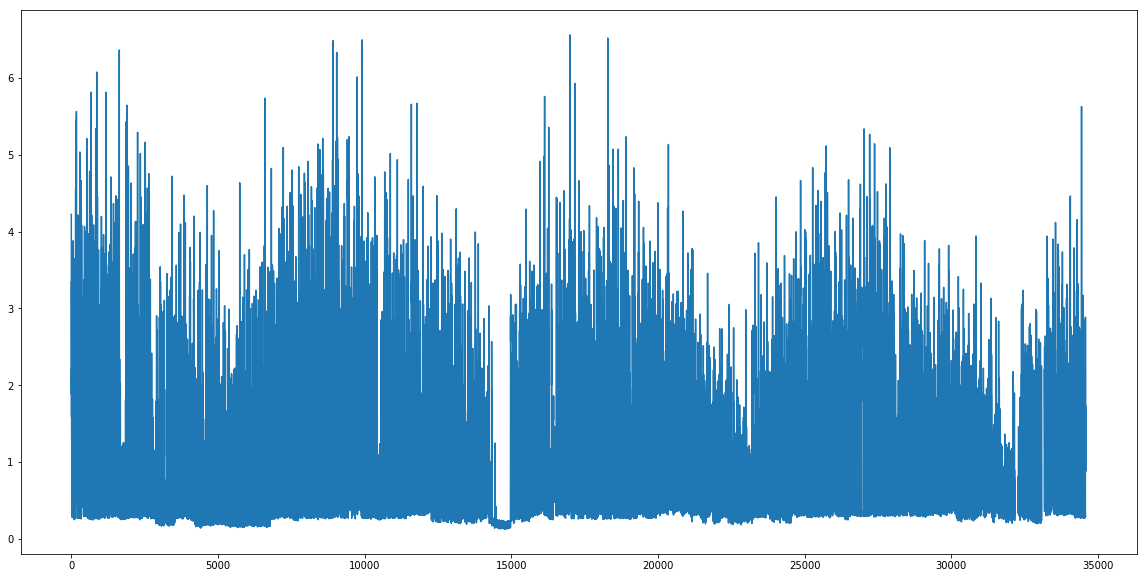

In [12]:
inp1['Global_active_power'].plot(figsize=(20,10))

In [13]:
sollistv2 = [datetime.date(2000, 6, 21), datetime.date(2000, 12, 21), datetime.date(2001, 6, 21), datetime.date(2001, 12, 21), datetime.date(2002, 6, 21), datetime.date(2002, 12, 22), datetime.date(2003, 6, 21), datetime.date(2003, 12, 22), datetime.date(2004, 6, 21), datetime.date(2004, 12, 21), datetime.date(2005, 6, 21), datetime.date(2005, 12, 21), datetime.date(2006, 6, 21), datetime.date(2006, 12, 22), datetime.date(2007, 6, 21), datetime.date(2007, 12, 22), datetime.date(2008, 6, 20), datetime.date(2008, 12, 21), datetime.date(2009, 6, 21), datetime.date(2009, 12, 21), datetime.date(2010, 6, 21), datetime.date(2010, 12, 21), datetime.date(2011, 6, 21), datetime.date(2011, 12, 22), datetime.date(2012, 6, 20), datetime.date(2012, 12, 21), datetime.date(2013, 6, 21), datetime.date(2013, 12, 21), datetime.date(2014, 6, 21), datetime.date(2014, 12, 21), datetime.date(2015, 6, 21), datetime.date(2015, 12, 22), datetime.date(2016, 6, 20), datetime.date(2016, 12, 21), datetime.date(2017, 6, 21), datetime.date(2017, 12, 21), datetime.date(2018, 6, 21), datetime.date(2018, 12, 21)]

You can build the _sollistv2_ array like its done here below, you could use this code in a file in the terminal on this Jupyter Notebook instance. You can then use the array for the code in the next cell. You would need to install pyephem using pip prior to running this program. Although for the purposes for this notebook, you don't have to run this again as the data output by this code will remain the same and has been assigned to the _sollistv2_ above.

```python
#!/usr/bin/env python

import ephem
import datetime

def main():
        sollist,sollistv2 = [],[]
        for yr in range(2000,2019):
                nsol1 = ephem.next_solstice(str(yr))
                nsol2 = ephem.next_solstice(nsol1)
                strdt = nsol1.datetime().strftime("%Y-%m-%d")
                sollist.append(strdt)
                sollistv2.append(datetime.datetime.strptime(sollist[-1],"%Y-%m-%d").date())
                strdt = nsol2.datetime().strftime("%Y-%m-%d")
                sollist.append(strdt)
                sollistv2.append(datetime.datetime.strptime(sollist[-1],"%Y-%m-%d").date())
        print(sollistv2)

if __name__=="__main__":
        main()
```

In [14]:
## We calculate the distances from solstices and return the values, the input is observation date 
## i.e. same name as the column in our dataframes(inputs). We then populate the other columns.
def getDistFromSolstices(obdt):
    indx = bisect.bisect(sollistv2,obdt.date())
    return (obdt.date() - sollistv2[indx-1]).days,(sollistv2[indx] - obdt.date()).days

def populateDistance(data):
    dsfromlast,dsfromnext = [],[]
    for row in data.itertuples():
        dfromlast,dfromnext = getDistFromSolstices(row[1]) #Get 'Date2' column
        dsfromlast.append(dfromlast)
        dsfromnext.append(dfromnext)
    data = data.assign(distanceFromLastSolstice=pd.Series(dsfromlast,index=data.index))
    data = data.assign(distanceFromNextSolstice=pd.Series(dsfromnext,index=data.index))
    return data

In [15]:
processedDF = populateDistance(inp1)

In [16]:
processedDF.head(48)

,Date2,TimeHrs,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,distanceFromLastSolstice,distanceFromNextSolstice
0,2006-12-16,17,4.222889,0.229000,234.643889,18.100000,0.000000,0.527778,16.861111,178,6
1,2006-12-16,18,3.632200,0.080033,234.580167,15.600000,0.000000,6.716667,16.866667,178,6
2,2006-12-16,19,3.400233,0.085233,233.232500,14.503333,0.000000,1.433333,16.683333,178,6
3,2006-12-16,20,3.268567,0.075100,234.071500,13.916667,0.000000,0.000000,16.783333,178,6
4,2006-12-16,21,3.056467,0.076667,237.158667,13.046667,0.000000,0.416667,17.216667,178,6
5,2006-12-16,22,2.200133,0.056167,238.760000,9.523333,0.000000,0.133333,4.433333,178,6
6,2006-12-16,23,2.061600,0.071433,240.619667,8.896667,0.000000,0.083333,0.000000,178,6
7,2006-12-17,0,1.882467,0.102433,240.961833,8.126667,0.000000,0.466667,0.000000,179,5
8,2006-12-17,1,3.349400,0.136933,240.448333,14.246667,0.000000,25.233333,0.000000,179,5
9,2006-12-17,2,1.587267,0.078233,245.818667,6.870000,0.000000,0.566667,0.000000,179,5


Fix all NaN values before we start writing this to a file.

In [17]:
processedDF.fillna(value="NaN",inplace=True)

In [18]:
## Building the training data 

trdata = []

## Category for Global Active Power, Sub-Meter-1,2,3 -> 0
starttime = str(processedDF.iloc[0]['Date2'])[:10] +' '+str(processedDF.iloc[0]['TimeHrs'])+':00:00'
target = processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['Global_active_power'].tolist()
cat = [0,0]
dynfeat = [processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['distanceFromLastSolstice'].tolist(),processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['distanceFromNextSolstice'].tolist()]
trdata.append({"start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat})

## llly, for sub-meter-1
target = processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['Sub_metering_1'].tolist()
cat = [0,1]
trdata.append({"start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat})

## llly, for sub-meter-2
target = processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['Sub_metering_2'].tolist()
cat = [0,2]
trdata.append({"start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat})

## llly, for sub-meter-2
target = processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['Sub_metering_3'].tolist()
cat = [0,3]
trdata.append({"start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat})

target = processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['Global_reactive_power'].tolist()
cat = [1,4]
trdata.append({"start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat})

target = processedDF[processedDF['Date2'] < pd.to_datetime('2008-01').date()]['Voltage'].tolist()
cat = [2,5]
trdata.append({"start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat})

random.shuffle(trdata)

f = open("trainingdata.json",'wb')
for datapoint in trdata:
    f.write(json.dumps(datapoint).encode("utf-8"))
    f.write("\n".encode('utf-8'))
f.close()

In [19]:
## Building the test data

tedata = []

## Category for Global Active Power, Sub-Meter-1,2,3 -> 0

starttime = str(processedDF[(processedDF['Date2'] == '2008-01')].iloc[0]['Date2'])[:10]+' '+ '0' + str(processedDF[processedDF['Date2'] == '2008-01'].iloc[0]['TimeHrs'])+':00:00'

target = processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['Global_active_power'].tolist()
cat = [0,0]
dynfeat = [processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['distanceFromLastSolstice'].tolist(),processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['distanceFromNextSolstice'].tolist()]
tedata.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

## llly, for sub-meter-1
target = processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['Sub_metering_1'].tolist()
cat = [0,1]
tedata.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

## llly, for sub-meter-2
target = processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['Sub_metering_2'].tolist()
cat = [0,2]
tedata.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

## llly, for sub-meter-2
target = processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['Sub_metering_3'].tolist()
cat = [0,3]
tedata.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

target = processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['Global_reactive_power'].tolist()
cat = [1,4]
tedata.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

target = processedDF[(processedDF['Date2'] >= '2008-01') & (processedDF['Date2'] < '2008-07')]['Voltage'].tolist()
cat = [2,5]
tedata.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

f = open("testdata.json",'wb')
for datapoint in tedata:
    f.write(json.dumps(datapoint).encode("utf-8"))
    f.write("\n".encode('utf-8'))
f.close()

In [20]:
training_key = 'trainingdata.json'
testing_key = 'testdata.json'
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix = '{}/{}'.format(prefix,'test')

## Lets create the sagemaker session and upload the data from where Amazon SageMaker will pick it 
## up to put in the container
sg_sess = Session()
training_path  = sg_sess.upload_data(training_key, bucket=bucket, key_prefix=train_prefix)
testing_path = sg_sess.upload_data(testing_key, bucket=bucket, key_prefix=test_prefix)

In [21]:
from sagemaker.amazon.amazon_estimator import get_image_uri

img = get_image_uri(boto3.Session().region_name,'forecasting-deepar')
prediction_length = 24 # hours ahead
context_length = 216 # hours prior

In [24]:
from time import gmtime, strftime

job_name = 'DevDay-DeepARTraining-' + strftime("%Y-%m-%d-%H-%M-%S",gmtime())
print(job_name)
                                
## We have already setup the containers above
                                
## We choose a different output location to keep these separate from our old artifacts
output_location = 's3://{}/{}/output'.format(bucket,prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": img,
        "TrainingInputMode": "File"
    },
    "RoleArn": roleARN,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 4,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 10
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "time_freq": 'H', # hourly series
        "context_length": str(context_length),
        "prediction_length": str(prediction_length), # number of data points to predict
        "num_dynamic_feat": "auto",
        "num_cells": "60", 
        "num_layers": "3",
        "likelihood": "gaussian", #real world data
        "epochs": "15", ## keep small, to save on time!!! 250 seems to give good results though
        "mini_batch_size": "128", ## keep large, to save on time!!! 128 seems to give good results though
        "learning_rate": "0.01",
        "dropout_rate": "0.1"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 240 # Give it four hours at best, could increase this for production scale
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": training_path,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "test",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": testing_path,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}

sgmaker = boto3.client('sagemaker')
sgmaker.create_training_job(**create_training_params)

## Lets check the status of the job to see if its complete, and lets wait until its done
status = sgmaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

## You can either wait for the job, like below, or do what we do in the next cell
#try:
#    sgmaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
#finally:
#    status = sgmaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
#    print("Training job ended with status: " + status)
#    if status == 'Failed':
#        message = sgmaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
#        print('Training failed with the following error: {}'.format(message))
#        raise Exception('Training job failed')

DevDay-DeepARTraining-2018-10-01-15-25-01
training artifacts will be uploaded to: s3://rnszsdemo/sagemaker/data/Household_Electricity_Consumption/output
InProgress


In [25]:
import sagemaker

tor = sagemaker.estimator.Estimator.attach(job_name)

2018-10-01 15:25:01 Starting - Launching requested ML instances............
Preparing the instances for training......
2018-10-01 15:28:00 Downloading - Downloading input data
2018-10-01 15:28:05 Training - Downloading the training image.
Arguments: train
Arguments: train
[10/01/2018 15:28:11 INFO 140196492334912] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/01/2018 15:28:11 INFO 140196492334912] Reading provided configuration from /opt/ml/input/config/


Training image download completed. Training in progress.#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 14911.645889282227, "sum": 14911.645889282227, "min": 14911.645889282227}}, "EndTime": 1538407708.934768, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407691.416248}

[10/01/2018 15:28:28 INFO 139663579178816] Number of GPUs being used: 0
#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 14934.770822525024, "sum": 14934.770822525024, "min": 14934.770822525024}}, "EndTime": 1538407708.955876, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407692.004713}

[10/01/2018 15:28:28 INFO 140196492334912] Number of GPUs being used: 0
#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 15029.124021530151, "sum": 15029.124021530151, "min": 15029.124021530151}}, "EndTime": 1538407709.052334, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algo

[10/01/2018 15:28:46 INFO 139663579178816] Epoch[1] Batch[5] avg_epoch_loss=3.158150
[10/01/2018 15:28:46 INFO 139663579178816] Epoch[1] Batch [5]#011Speed: 163.66 samples/sec#011loss=3.158150
[10/01/2018 15:28:47 INFO 140252856112960] Epoch[1] Batch[5] avg_epoch_loss=3.296534
[10/01/2018 15:28:47 INFO 140252856112960] Epoch[1] Batch [5]#011Speed: 146.98 samples/sec#011loss=3.296534
[10/01/2018 15:28:48 INFO 140196492334912] Epoch[1] Batch[5] avg_epoch_loss=3.222671
[10/01/2018 15:28:48 INFO 140196492334912] Epoch[1] Batch [5]#011Speed: 120.44 samples/sec#011loss=3.222671
[10/01/2018 15:28:50 INFO 139663579178816] processed a total of 1259 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 9810.744047164917, "sum": 9810.744047164917, "min": 9810.744047164917}}, "EndTime": 1538407730.071515, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407720.260523}

[10/01/2018 15:28:50 INFO 139663579178816] #throughput_metric: h

[10/01/2018 15:29:08 INFO 139663579178816] Epoch[3] Batch[5] avg_epoch_loss=3.086981
[10/01/2018 15:29:08 INFO 139663579178816] Epoch[3] Batch [5]#011Speed: 125.61 samples/sec#011loss=3.086981
[10/01/2018 15:29:10 INFO 140196492334912] Epoch[3] Batch[5] avg_epoch_loss=3.175690
[10/01/2018 15:29:10 INFO 140196492334912] Epoch[3] Batch [5]#011Speed: 124.43 samples/sec#011loss=3.175690
[10/01/2018 15:29:09 INFO 140252856112960] Epoch[3] Batch[5] avg_epoch_loss=3.092533
[10/01/2018 15:29:09 INFO 140252856112960] Epoch[3] Batch [5]#011Speed: 120.78 samples/sec#011loss=3.092533
[10/01/2018 15:29:11 INFO 139663579178816] processed a total of 1280 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10414.896965026855, "sum": 10414.896965026855, "min": 10414.896965026855}}, "EndTime": 1538407751.941965, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407741.526841}

[10/01/2018 15:29:11 INFO 139663579178816] #throughput_metric

[10/01/2018 15:29:37 INFO 140624803325760] Epoch[5] Batch[10] avg_epoch_loss=2.749562
[10/01/2018 15:29:37 INFO 140624803325760] Epoch[5] Batch [10]#011Speed: 120.62 samples/sec#011loss=2.517971
[10/01/2018 15:29:37 INFO 140624803325760] processed a total of 1288 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11842.89002418518, "sum": 11842.89002418518, "min": 11842.89002418518}}, "EndTime": 1538407777.077486, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407765.234368}

[10/01/2018 15:29:37 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=108.756293586 records/second
[10/01/2018 15:29:37 INFO 140624803325760] #progress_metric: host=algo-3, completed 2 % of epochs
[10/01/2018 15:29:37 INFO 140252856112960] Epoch[5] Batch[10] avg_epoch_loss=3.225192
[10/01/2018 15:29:37 INFO 140252856112960] Epoch[5] Batch [10]#011Speed: 116.68 samples/sec#011loss=3.401658
[10/01/2018 15:29:37 INFO 1402528

[10/01/2018 15:29:58 INFO 140196492334912] Epoch[7] Batch[10] avg_epoch_loss=2.797138
[10/01/2018 15:29:58 INFO 140196492334912] Epoch[7] Batch [10]#011Speed: 116.57 samples/sec#011loss=2.699192
[10/01/2018 15:29:58 INFO 140196492334912] processed a total of 1328 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12191.917181015015, "sum": 12191.917181015015, "min": 12191.917181015015}}, "EndTime": 1538407798.874703, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407786.682547}

[10/01/2018 15:29:58 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=108.923812877 records/second
[10/01/2018 15:29:58 INFO 140196492334912] #progress_metric: host=algo-4, completed 3 % of epochs
[10/01/2018 15:29:58 INFO 140624803325760] processed a total of 1258 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10475.82197189331, "sum": 10475.82197189331, "min": 10475.82197189331}}, "EndTime": 153840

[10/01/2018 15:30:28 INFO 140624803325760] Epoch[10] Batch[5] avg_epoch_loss=2.451314
[10/01/2018 15:30:28 INFO 140624803325760] Epoch[10] Batch [5]#011Speed: 119.00 samples/sec#011loss=2.451314
[10/01/2018 15:30:29 INFO 139663579178816] Epoch[10] Batch[10] avg_epoch_loss=2.741024
[10/01/2018 15:30:29 INFO 139663579178816] Epoch[10] Batch [10]#011Speed: 113.18 samples/sec#011loss=2.749351
[10/01/2018 15:30:29 INFO 139663579178816] processed a total of 1290 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12501.466989517212, "sum": 12501.466989517212, "min": 12501.466989517212}}, "EndTime": 1538407829.85175, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407817.350025}

[10/01/2018 15:30:29 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=103.186858775 records/second
[10/01/2018 15:30:29 INFO 139663579178816] #progress_metric: host=algo-2, completed 4 % of epochs
[10/01/2018 15:30:31 INFO 139

[10/01/2018 15:30:50 INFO 140196492334912] Epoch[12] Batch[5] avg_epoch_loss=2.529488
[10/01/2018 15:30:50 INFO 140196492334912] Epoch[12] Batch [5]#011Speed: 113.88 samples/sec#011loss=2.529488
[10/01/2018 15:30:53 INFO 140252856112960] Epoch[12] Batch[5] avg_epoch_loss=2.479917
[10/01/2018 15:30:53 INFO 140252856112960] Epoch[12] Batch [5]#011Speed: 114.88 samples/sec#011loss=2.479917
[10/01/2018 15:30:54 INFO 139663579178816] Epoch[13] Batch[0] avg_epoch_loss=2.655368
[10/01/2018 15:30:55 INFO 140196492334912] Epoch[12] Batch[10] avg_epoch_loss=2.679373
[10/01/2018 15:30:55 INFO 140196492334912] Epoch[12] Batch [10]#011Speed: 139.94 samples/sec#011loss=2.859235
[10/01/2018 15:30:55 INFO 140196492334912] processed a total of 1287 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11911.39006614685, "sum": 11911.39006614685, "min": 11911.39006614685}}, "EndTime": 1538407855.492513, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "St

[10/01/2018 15:31:11 INFO 140252856112960] Epoch[14] Batch[0] avg_epoch_loss=2.287405
[10/01/2018 15:31:14 INFO 139663579178816] Epoch[15] Batch[0] avg_epoch_loss=2.395024
[10/01/2018 15:31:15 INFO 140196492334912] Epoch[14] Batch[5] avg_epoch_loss=2.411259
[10/01/2018 15:31:15 INFO 140196492334912] Epoch[14] Batch [5]#011Speed: 110.10 samples/sec#011loss=2.411259
[10/01/2018 15:31:16 INFO 140252856112960] Epoch[14] Batch[5] avg_epoch_loss=2.336063
[10/01/2018 15:31:16 INFO 140252856112960] Epoch[14] Batch [5]#011Speed: 145.83 samples/sec#011loss=2.336063
[10/01/2018 15:31:18 INFO 139663579178816] Epoch[15] Batch[5] avg_epoch_loss=2.359406
[10/01/2018 15:31:18 INFO 139663579178816] Epoch[15] Batch [5]#011Speed: 150.03 samples/sec#011loss=2.359406
[10/01/2018 15:31:18 INFO 140624803325760] Epoch[14] Batch[10] avg_epoch_loss=2.124298
[10/01/2018 15:31:18 INFO 140624803325760] Epoch[14] Batch [10]#011Speed: 118.37 samples/sec#011loss=1.757606
[10/01/2018 15:31:18 INFO 140624803325760] pro

[10/01/2018 15:31:42 INFO 140624803325760] Epoch[17] Batch[0] avg_epoch_loss=2.222067
[10/01/2018 15:31:44 INFO 140196492334912] Epoch[16] Batch[10] avg_epoch_loss=2.615141
[10/01/2018 15:31:44 INFO 140196492334912] Epoch[16] Batch [10]#011Speed: 140.27 samples/sec#011loss=2.951127
[10/01/2018 15:31:44 INFO 140196492334912] processed a total of 1295 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11789.685010910034, "sum": 11789.685010910034, "min": 11789.685010910034}}, "EndTime": 1538407904.596074, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407892.806166}

[10/01/2018 15:31:44 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=109.840848148 records/second
[10/01/2018 15:31:44 INFO 140196492334912] #progress_metric: host=algo-4, completed 6 % of epochs
[10/01/2018 15:31:46 INFO 139663579178816] Epoch[17] Batch[10] avg_epoch_loss=2.276344
[10/01/2018 15:31:46 INFO 139663579178816] Epoch[1

[10/01/2018 15:32:14 INFO 140196492334912] Epoch[19] Batch[5] avg_epoch_loss=2.355883
[10/01/2018 15:32:14 INFO 140196492334912] Epoch[19] Batch [5]#011Speed: 113.39 samples/sec#011loss=2.355883
[10/01/2018 15:32:15 INFO 140252856112960] Epoch[19] Batch[5] avg_epoch_loss=2.402911
[10/01/2018 15:32:15 INFO 140252856112960] Epoch[19] Batch [5]#011Speed: 116.70 samples/sec#011loss=2.402911
[10/01/2018 15:32:16 INFO 140624803325760] Epoch[20] Batch[0] avg_epoch_loss=3.015562
[10/01/2018 15:32:16 INFO 139663579178816] Epoch[20] Batch[5] avg_epoch_loss=2.327552
[10/01/2018 15:32:16 INFO 139663579178816] Epoch[20] Batch [5]#011Speed: 147.47 samples/sec#011loss=2.327552
[10/01/2018 15:32:19 INFO 140196492334912] processed a total of 1261 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11291.840076446533, "sum": 11291.840076446533, "min": 11291.840076446533}}, "EndTime": 1538407939.004812, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "S

[10/01/2018 15:32:44 INFO 139663579178816] Epoch[23] Batch[0] avg_epoch_loss=2.369803
[10/01/2018 15:32:49 INFO 140624803325760] Epoch[23] Batch[0] avg_epoch_loss=2.346704
[10/01/2018 15:32:49 INFO 140252856112960] Epoch[22] Batch[5] avg_epoch_loss=2.147310
[10/01/2018 15:32:49 INFO 140252856112960] Epoch[22] Batch [5]#011Speed: 119.67 samples/sec#011loss=2.147310
[10/01/2018 15:32:50 INFO 139663579178816] Epoch[23] Batch[5] avg_epoch_loss=2.230260
[10/01/2018 15:32:50 INFO 139663579178816] Epoch[23] Batch [5]#011Speed: 118.83 samples/sec#011loss=2.230260
[10/01/2018 15:32:51 INFO 140196492334912] processed a total of 1252 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10313.658952713013, "sum": 10313.658952713013, "min": 10313.658952713013}}, "EndTime": 1538407971.626758, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407961.312855}

[10/01/2018 15:32:51 INFO 140196492334912] #throughput_metric: host=algo-4, tr

[10/01/2018 15:33:11 INFO 140252856112960] Epoch[24] Batch[5] avg_epoch_loss=2.267479
[10/01/2018 15:33:11 INFO 140252856112960] Epoch[24] Batch [5]#011Speed: 119.69 samples/sec#011loss=2.267479
[10/01/2018 15:33:14 INFO 140196492334912] processed a total of 1241 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10667.255878448486, "sum": 10667.255878448486, "min": 10667.255878448486}}, "EndTime": 1538407994.12941, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538407983.461927}

[10/01/2018 15:33:14 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=116.335688187 records/second
[10/01/2018 15:33:14 INFO 140196492334912] #progress_metric: host=algo-4, completed 10 % of epochs
[10/01/2018 15:33:15 INFO 140196492334912] Epoch[25] Batch[0] avg_epoch_loss=2.224138
[10/01/2018 15:33:16 INFO 140252856112960] Epoch[24] Batch[10] avg_epoch_loss=2.279306
[10/01/2018 15:33:16 INFO 140252856112960] Epoch[24]

[10/01/2018 15:33:39 INFO 140624803325760] Epoch[27] Batch[5] avg_epoch_loss=2.257186
[10/01/2018 15:33:39 INFO 140624803325760] Epoch[27] Batch [5]#011Speed: 120.81 samples/sec#011loss=2.257186
[10/01/2018 15:33:44 INFO 140196492334912] Epoch[27] Batch[5] avg_epoch_loss=2.185365
[10/01/2018 15:33:44 INFO 140196492334912] Epoch[27] Batch [5]#011Speed: 119.70 samples/sec#011loss=2.185365
[10/01/2018 15:33:43 INFO 140624803325760] Epoch[27] Batch[10] avg_epoch_loss=2.003087
[10/01/2018 15:33:43 INFO 140624803325760] Epoch[27] Batch [10]#011Speed: 147.63 samples/sec#011loss=1.698168
[10/01/2018 15:33:43 INFO 140624803325760] processed a total of 1298 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11261.396884918213, "sum": 11261.396884918213, "min": 11261.396884918213}}, "EndTime": 1538408023.81446, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408012.552847}

[10/01/2018 15:33:43 INFO 140624803325760] #throughput

[10/01/2018 15:34:09 INFO 140196492334912] processed a total of 1268 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10236.187934875488, "sum": 10236.187934875488, "min": 10236.187934875488}}, "EndTime": 1538408049.372863, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408039.136447}

[10/01/2018 15:34:09 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=123.872895399 records/second
[10/01/2018 15:34:09 INFO 140196492334912] #progress_metric: host=algo-4, completed 12 % of epochs
[10/01/2018 15:34:11 INFO 140196492334912] Epoch[30] Batch[0] avg_epoch_loss=1.927061
[10/01/2018 15:34:10 INFO 139663579178816] Epoch[30] Batch[10] avg_epoch_loss=1.830015
[10/01/2018 15:34:10 INFO 139663579178816] Epoch[30] Batch [10]#011Speed: 115.68 samples/sec#011loss=1.327075
[10/01/2018 15:34:10 INFO 139663579178816] processed a total of 1287 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1

[10/01/2018 15:34:34 INFO 139663579178816] Epoch[33] Batch[0] avg_epoch_loss=2.171201
[10/01/2018 15:34:33 INFO 140624803325760] Epoch[32] Batch[5] avg_epoch_loss=2.345856
[10/01/2018 15:34:33 INFO 140624803325760] Epoch[32] Batch [5]#011Speed: 121.63 samples/sec#011loss=2.345856
[10/01/2018 15:34:35 INFO 140252856112960] Epoch[32] Batch[0] avg_epoch_loss=2.127245
[10/01/2018 15:34:36 INFO 140196492334912] Epoch[32] Batch[5] avg_epoch_loss=2.071802
[10/01/2018 15:34:36 INFO 140196492334912] Epoch[32] Batch [5]#011Speed: 154.84 samples/sec#011loss=2.071802
[10/01/2018 15:34:38 INFO 140624803325760] Epoch[32] Batch[10] avg_epoch_loss=2.534755
[10/01/2018 15:34:38 INFO 140624803325760] Epoch[32] Batch [10]#011Speed: 144.76 samples/sec#011loss=2.761435
[10/01/2018 15:34:38 INFO 140624803325760] processed a total of 1285 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11354.028940200806, "sum": 11354.028940200806, "min": 11354.028940200806}}, "EndTime": 1538408078.271238, 

[10/01/2018 15:35:02 INFO 140252856112960] Epoch[34] Batch[5] avg_epoch_loss=2.156048
[10/01/2018 15:35:02 INFO 140252856112960] Epoch[34] Batch [5]#011Speed: 120.65 samples/sec#011loss=2.156048
[10/01/2018 15:35:04 INFO 140196492334912] Epoch[35] Batch[0] avg_epoch_loss=2.101579
[10/01/2018 15:35:06 INFO 140252856112960] processed a total of 1263 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10829.791069030762, "sum": 10829.791069030762, "min": 10829.791069030762}}, "EndTime": 1538408106.392603, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408095.562528}

[10/01/2018 15:35:06 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=116.621585439 records/second
[10/01/2018 15:35:06 INFO 140252856112960] #progress_metric: host=algo-1, completed 14 % of epochs
[10/01/2018 15:35:06 INFO 139663579178816] Epoch[36] Batch[0] avg_epoch_loss=2.101382
[10/01/2018 15:35:08 INFO 140252856112960] Epoch[35]

[10/01/2018 15:35:36 INFO 140196492334912] processed a total of 1251 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10479.304075241089, "sum": 10479.304075241089, "min": 10479.304075241089}}, "EndTime": 1538408136.25904, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408125.779519}

[10/01/2018 15:35:36 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=119.376904247 records/second
[10/01/2018 15:35:36 INFO 140196492334912] #progress_metric: host=algo-4, completed 15 % of epochs
[10/01/2018 15:35:34 INFO 139663579178816] Epoch[38] Batch[5] avg_epoch_loss=2.117144
[10/01/2018 15:35:34 INFO 139663579178816] Epoch[38] Batch [5]#011Speed: 123.30 samples/sec#011loss=2.117144
[10/01/2018 15:35:34 INFO 140624803325760] Epoch[38] Batch[0] avg_epoch_loss=2.232900
[10/01/2018 15:35:37 INFO 140196492334912] Epoch[38] Batch[0] avg_epoch_loss=2.588861
[10/01/2018 15:35:38 INFO 140252856112960] processed 

[10/01/2018 15:36:02 INFO 140252856112960] Epoch[39] Batch[10] avg_epoch_loss=2.199580
[10/01/2018 15:36:02 INFO 140252856112960] Epoch[39] Batch [10]#011Speed: 144.22 samples/sec#011loss=1.964630
[10/01/2018 15:36:02 INFO 140252856112960] processed a total of 1307 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11501.657009124756, "sum": 11501.657009124756, "min": 11501.657009124756}}, "EndTime": 1538408162.179186, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408150.67729}

[10/01/2018 15:36:02 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=113.634763948 records/second
[10/01/2018 15:36:02 INFO 140252856112960] #progress_metric: host=algo-1, completed 16 % of epochs
[10/01/2018 15:36:02 INFO 139663579178816] Epoch[41] Batch[0] avg_epoch_loss=2.281615
[10/01/2018 15:36:04 INFO 140252856112960] Epoch[40] Batch[0] avg_epoch_loss=1.916929
[10/01/2018 15:36:05 INFO 140624803325760] processe

[10/01/2018 15:36:28 INFO 140196492334912] Epoch[42] Batch[5] avg_epoch_loss=2.257169
[10/01/2018 15:36:28 INFO 140196492334912] Epoch[42] Batch [5]#011Speed: 150.33 samples/sec#011loss=2.257169
[10/01/2018 15:36:29 INFO 139663579178816] Epoch[43] Batch[5] avg_epoch_loss=2.183097
[10/01/2018 15:36:29 INFO 139663579178816] Epoch[43] Batch [5]#011Speed: 122.99 samples/sec#011loss=2.183097
[10/01/2018 15:36:32 INFO 140624803325760] Epoch[43] Batch[5] avg_epoch_loss=2.163809
[10/01/2018 15:36:32 INFO 140624803325760] Epoch[43] Batch [5]#011Speed: 157.63 samples/sec#011loss=2.163809
[10/01/2018 15:36:32 INFO 140252856112960] Epoch[42] Batch[5] avg_epoch_loss=2.289991
[10/01/2018 15:36:32 INFO 140252856112960] Epoch[42] Batch [5]#011Speed: 118.23 samples/sec#011loss=2.289991
[10/01/2018 15:36:33 INFO 139663579178816] processed a total of 1254 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10511.999130249023, "sum": 10511.999130249023, "min": 10511.999130249023}}, "EndTime"

[10/01/2018 15:37:01 INFO 140624803325760] Epoch[46] Batch[0] avg_epoch_loss=1.949112
[10/01/2018 15:37:00 INFO 140252856112960] Epoch[45] Batch[0] avg_epoch_loss=2.169583
[10/01/2018 15:37:01 INFO 139663579178816] Epoch[46] Batch[5] avg_epoch_loss=2.190768
[10/01/2018 15:37:01 INFO 139663579178816] Epoch[46] Batch [5]#011Speed: 152.57 samples/sec#011loss=2.190768
[10/01/2018 15:37:02 INFO 140196492334912] Epoch[45] Batch[5] avg_epoch_loss=2.176479
[10/01/2018 15:37:02 INFO 140196492334912] Epoch[45] Batch [5]#011Speed: 152.64 samples/sec#011loss=2.176479
[10/01/2018 15:37:04 INFO 140252856112960] Epoch[45] Batch[5] avg_epoch_loss=2.237406
[10/01/2018 15:37:04 INFO 140252856112960] Epoch[45] Batch [5]#011Speed: 154.56 samples/sec#011loss=2.237406
[10/01/2018 15:37:06 INFO 140624803325760] Epoch[46] Batch[5] avg_epoch_loss=2.054941
[10/01/2018 15:37:06 INFO 140624803325760] Epoch[46] Batch [5]#011Speed: 123.16 samples/sec#011loss=2.054941
[10/01/2018 15:37:06 INFO 139663579178816] Epoch

[10/01/2018 15:37:32 INFO 140196492334912] Epoch[48] Batch[0] avg_epoch_loss=2.100509
[10/01/2018 15:37:33 INFO 140624803325760] Epoch[49] Batch[0] avg_epoch_loss=2.083270
[10/01/2018 15:37:33 INFO 140252856112960] Epoch[47] Batch[10] avg_epoch_loss=2.146202
[10/01/2018 15:37:33 INFO 140252856112960] Epoch[47] Batch [10]#011Speed: 120.43 samples/sec#011loss=2.103303
[10/01/2018 15:37:33 INFO 140252856112960] processed a total of 1301 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11844.794034957886, "sum": 11844.794034957886, "min": 11844.794034957886}}, "EndTime": 1538408253.230409, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408241.385385}

[10/01/2018 15:37:33 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=109.836310693 records/second
[10/01/2018 15:37:33 INFO 140252856112960] #progress_metric: host=algo-1, completed 19 % of epochs
[10/01/2018 15:37:34 INFO 139663579178816] Epoch[4

[10/01/2018 15:38:00 INFO 140252856112960] Epoch[50] Batch[5] avg_epoch_loss=1.996671
[10/01/2018 15:38:00 INFO 140252856112960] Epoch[50] Batch [5]#011Speed: 155.88 samples/sec#011loss=1.996671
[10/01/2018 15:38:06 INFO 140196492334912] Epoch[51] Batch[0] avg_epoch_loss=1.819067
[10/01/2018 15:38:06 INFO 140624803325760] Epoch[52] Batch[0] avg_epoch_loss=2.159172
[10/01/2018 15:38:06 INFO 140252856112960] Epoch[50] Batch[10] avg_epoch_loss=1.787299
[10/01/2018 15:38:06 INFO 140252856112960] Epoch[50] Batch [10]#011Speed: 121.72 samples/sec#011loss=1.536052
[10/01/2018 15:38:06 INFO 140252856112960] processed a total of 1305 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11706.650972366333, "sum": 11706.650972366333, "min": 11706.650972366333}}, "EndTime": 1538408286.22852, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408274.521636}

[10/01/2018 15:38:06 INFO 140252856112960] #throughput_metric: host=algo-1, t

[10/01/2018 15:38:33 INFO 140624803325760] Epoch[54] Batch[5] avg_epoch_loss=2.147828
[10/01/2018 15:38:33 INFO 140624803325760] Epoch[54] Batch [5]#011Speed: 121.93 samples/sec#011loss=2.147828
[10/01/2018 15:38:34 INFO 140196492334912] Epoch[53] Batch[5] avg_epoch_loss=2.208250
[10/01/2018 15:38:34 INFO 140196492334912] Epoch[53] Batch [5]#011Speed: 150.54 samples/sec#011loss=2.208250
[10/01/2018 15:38:35 INFO 139663579178816] Epoch[55] Batch[0] avg_epoch_loss=1.839947
[10/01/2018 15:38:37 INFO 140624803325760] processed a total of 1255 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10626.161098480225, "sum": 10626.161098480225, "min": 10626.161098480225}}, "EndTime": 1538408317.442622, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408306.816142}

[10/01/2018 15:38:37 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=118.103564042 records/second
[10/01/2018 15:38:37 INFO 140624803325760]

[10/01/2018 15:39:03 INFO 140252856112960] Epoch[55] Batch[10] avg_epoch_loss=2.149027
[10/01/2018 15:39:03 INFO 140252856112960] Epoch[55] Batch [10]#011Speed: 115.97 samples/sec#011loss=2.203435
[10/01/2018 15:39:03 INFO 140252856112960] processed a total of 1297 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12240.357160568237, "sum": 12240.357160568237, "min": 12240.357160568237}}, "EndTime": 1538408343.946388, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408331.705802}

[10/01/2018 15:39:03 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=105.959965572 records/second
[10/01/2018 15:39:03 INFO 140252856112960] #progress_metric: host=algo-1, completed 22 % of epochs
[10/01/2018 15:39:05 INFO 140624803325760] Epoch[57] Batch[5] avg_epoch_loss=2.167389
[10/01/2018 15:39:05 INFO 140624803325760] Epoch[57] Batch [5]#011Speed: 123.90 samples/sec#011loss=2.167389
[10/01/2018 15:39:05 INFO 1

[10/01/2018 15:39:24 INFO 139663579178816] Epoch[59] Batch[5] avg_epoch_loss=2.186164
[10/01/2018 15:39:24 INFO 139663579178816] Epoch[59] Batch [5]#011Speed: 123.35 samples/sec#011loss=2.186164
[10/01/2018 15:39:26 INFO 140196492334912] Epoch[58] Batch[0] avg_epoch_loss=1.835608
[10/01/2018 15:39:27 INFO 140252856112960] Epoch[58] Batch[0] avg_epoch_loss=2.224946
[10/01/2018 15:39:29 INFO 139663579178816] Epoch[59] Batch[10] avg_epoch_loss=2.147505
[10/01/2018 15:39:29 INFO 139663579178816] Epoch[59] Batch [10]#011Speed: 147.87 samples/sec#011loss=2.101114
[10/01/2018 15:39:29 INFO 139663579178816] processed a total of 1288 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11180.145978927612, "sum": 11180.145978927612, "min": 11180.145978927612}}, "EndTime": 1538408369.233591, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408358.053207}

[10/01/2018 15:39:29 INFO 139663579178816] #throughput_metric: host=algo-2, 

[10/01/2018 15:39:53 INFO 139663579178816] Epoch[62] Batch[0] avg_epoch_loss=2.310906
[10/01/2018 15:39:55 INFO 140196492334912] Epoch[60] Batch[5] avg_epoch_loss=2.072087
[10/01/2018 15:39:55 INFO 140196492334912] Epoch[60] Batch [5]#011Speed: 119.78 samples/sec#011loss=2.072087
[10/01/2018 15:39:57 INFO 140624803325760] Epoch[62] Batch[5] avg_epoch_loss=2.142421
[10/01/2018 15:39:57 INFO 140624803325760] Epoch[62] Batch [5]#011Speed: 158.24 samples/sec#011loss=2.142421
[10/01/2018 15:39:59 INFO 139663579178816] Epoch[62] Batch[5] avg_epoch_loss=2.148562
[10/01/2018 15:39:59 INFO 139663579178816] Epoch[62] Batch [5]#011Speed: 121.32 samples/sec#011loss=2.148562
[10/01/2018 15:39:59 INFO 140196492334912] processed a total of 1227 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10839.322090148926, "sum": 10839.322090148926, "min": 10839.322090148926}}, "EndTime": 1538408399.202291, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "S

[10/01/2018 15:40:26 INFO 140624803325760] Epoch[65] Batch[0] avg_epoch_loss=1.965956
[10/01/2018 15:40:26 INFO 139663579178816] Epoch[64] Batch[10] avg_epoch_loss=1.986401
[10/01/2018 15:40:26 INFO 139663579178816] Epoch[64] Batch [10]#011Speed: 148.13 samples/sec#011loss=1.845378
[10/01/2018 15:40:26 INFO 139663579178816] processed a total of 1308 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11220.249891281128, "sum": 11220.249891281128, "min": 11220.249891281128}}, "EndTime": 1538408426.522016, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408415.301527}

[10/01/2018 15:40:26 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=116.573851367 records/second
[10/01/2018 15:40:26 INFO 139663579178816] #progress_metric: host=algo-2, completed 26 % of epochs
[10/01/2018 15:40:27 INFO 140252856112960] Epoch[63] Batch[5] avg_epoch_loss=2.069936
[10/01/2018 15:40:27 INFO 140252856112960] Epoch[6

[10/01/2018 15:40:48 INFO 140252856112960] Epoch[65] Batch[5] avg_epoch_loss=2.161195
[10/01/2018 15:40:48 INFO 140252856112960] Epoch[65] Batch [5]#011Speed: 154.59 samples/sec#011loss=2.161195
[10/01/2018 15:40:50 INFO 139663579178816] Epoch[67] Batch[0] avg_epoch_loss=1.711550
[10/01/2018 15:40:50 INFO 140196492334912] Epoch[65] Batch[5] avg_epoch_loss=2.177484
[10/01/2018 15:40:51 INFO 140196492334912] Epoch[65] Batch [5]#011Speed: 119.95 samples/sec#011loss=2.177484
[10/01/2018 15:40:52 INFO 140624803325760] Epoch[67] Batch[5] avg_epoch_loss=2.199855
[10/01/2018 15:40:52 INFO 140624803325760] Epoch[67] Batch [5]#011Speed: 156.88 samples/sec#011loss=2.199855
[10/01/2018 15:40:53 INFO 140252856112960] Epoch[65] Batch[10] avg_epoch_loss=2.195971
[10/01/2018 15:40:53 INFO 140252856112960] Epoch[65] Batch [10]#011Speed: 120.59 samples/sec#011loss=2.237703
[10/01/2018 15:40:53 INFO 140252856112960] processed a total of 1294 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max

[10/01/2018 15:41:17 INFO 139663579178816] Epoch[69] Batch[5] avg_epoch_loss=2.025139
[10/01/2018 15:41:17 INFO 139663579178816] Epoch[69] Batch [5]#011Speed: 120.77 samples/sec#011loss=2.025139
[10/01/2018 15:41:18 INFO 140196492334912] Epoch[67] Batch[10] avg_epoch_loss=1.894688
[10/01/2018 15:41:18 INFO 140196492334912] Epoch[67] Batch [10]#011Speed: 117.53 samples/sec#011loss=1.518396
[10/01/2018 15:41:18 INFO 140196492334912] processed a total of 1297 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12008.145093917847, "sum": 12008.145093917847, "min": 12008.145093917847}}, "EndTime": 1538408478.115937, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408466.107542}

[10/01/2018 15:41:18 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=108.008753296 records/second
[10/01/2018 15:41:18 INFO 140196492334912] #progress_metric: host=algo-4, completed 27 % of epochs
[10/01/2018 15:41:19 INFO 1

[10/01/2018 15:41:38 INFO 139663579178816] Epoch[71] Batch[5] avg_epoch_loss=2.153151
[10/01/2018 15:41:38 INFO 139663579178816] Epoch[71] Batch [5]#011Speed: 121.68 samples/sec#011loss=2.153151
[10/01/2018 15:41:39 INFO 140196492334912] processed a total of 1225 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10427.824020385742, "sum": 10427.824020385742, "min": 10427.824020385742}}, "EndTime": 1538408499.931794, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408489.50372}

[10/01/2018 15:41:39 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=117.472698177 records/second
[10/01/2018 15:41:39 INFO 140196492334912] #progress_metric: host=algo-4, completed 28 % of epochs
[10/01/2018 15:41:42 INFO 140196492334912] Epoch[70] Batch[0] avg_epoch_loss=2.255774
[10/01/2018 15:41:42 INFO 140624803325760] Epoch[72] Batch[0] avg_epoch_loss=2.374679
[10/01/2018 15:41:42 INFO 139663579178816] processed 

[10/01/2018 15:42:09 INFO 140624803325760] Epoch[74] Batch[5] avg_epoch_loss=2.113564
[10/01/2018 15:42:09 INFO 140624803325760] Epoch[74] Batch [5]#011Speed: 144.63 samples/sec#011loss=2.113564
[10/01/2018 15:42:11 INFO 140196492334912] processed a total of 1275 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10680.16004562378, "sum": 10680.16004562378, "min": 10680.16004562378}}, "EndTime": 1538408531.563927, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408520.883518}

[10/01/2018 15:42:11 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=119.379004949 records/second
[10/01/2018 15:42:11 INFO 140196492334912] #progress_metric: host=algo-4, completed 29 % of epochs
[10/01/2018 15:42:11 INFO 140252856112960] processed a total of 1224 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10406.605005264282, "sum": 10406.605005264282, "min": 10406.605005264282}}, "EndTime": 15384

[10/01/2018 15:42:30 INFO 140252856112960] Epoch[74] Batch[5] avg_epoch_loss=2.297945
[10/01/2018 15:42:30 INFO 140252856112960] Epoch[74] Batch [5]#011Speed: 121.25 samples/sec#011loss=2.297945
[10/01/2018 15:42:32 INFO 140624803325760] Epoch[76] Batch[5] avg_epoch_loss=2.533968
[10/01/2018 15:42:32 INFO 140624803325760] Epoch[76] Batch [5]#011Speed: 152.71 samples/sec#011loss=2.533968
[10/01/2018 15:42:34 INFO 140252856112960] Epoch[74] Batch[10] avg_epoch_loss=2.092243
[10/01/2018 15:42:34 INFO 140252856112960] Epoch[74] Batch [10]#011Speed: 150.00 samples/sec#011loss=1.845401
[10/01/2018 15:42:34 INFO 140252856112960] processed a total of 1329 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11164.024114608765, "sum": 11164.024114608765, "min": 11164.024114608765}}, "EndTime": 1538408554.378319, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408543.214055}

[10/01/2018 15:42:34 INFO 140252856112960] #throughpu

[10/01/2018 15:43:02 INFO 139663579178816] Epoch[78] Batch[10] avg_epoch_loss=2.301226
[10/01/2018 15:43:02 INFO 139663579178816] Epoch[78] Batch [10]#011Speed: 120.78 samples/sec#011loss=2.329419
[10/01/2018 15:43:02 INFO 139663579178816] processed a total of 1295 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11780.853033065796, "sum": 11780.853033065796, "min": 11780.853033065796}}, "EndTime": 1538408582.494736, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408570.713636}

[10/01/2018 15:43:02 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=109.923147225 records/second
[10/01/2018 15:43:02 INFO 139663579178816] #progress_metric: host=algo-2, completed 31 % of epochs
[10/01/2018 15:43:03 INFO 140252856112960] Epoch[77] Batch[5] avg_epoch_loss=2.165469
[10/01/2018 15:43:03 INFO 140252856112960] Epoch[77] Batch [5]#011Speed: 121.05 samples/sec#011loss=2.165469
[10/01/2018 15:43:04 INFO 1

[10/01/2018 15:43:32 INFO 140196492334912] Epoch[79] Batch[10] avg_epoch_loss=2.428449
[10/01/2018 15:43:32 INFO 140196492334912] Epoch[79] Batch [10]#011Speed: 117.23 samples/sec#011loss=2.548964
[10/01/2018 15:43:32 INFO 140196492334912] processed a total of 1312 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12038.702011108398, "sum": 12038.702011108398, "min": 12038.702011108398}}, "EndTime": 1538408612.358655, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408600.319708}

[10/01/2018 15:43:32 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=108.980743562 records/second
[10/01/2018 15:43:32 INFO 140196492334912] #progress_metric: host=algo-4, completed 32 % of epochs
[10/01/2018 15:43:33 INFO 140624803325760] Epoch[82] Batch[0] avg_epoch_loss=1.705055
[10/01/2018 15:43:33 INFO 140196492334912] Epoch[80] Batch[0] avg_epoch_loss=2.017328
[10/01/2018 15:43:37 INFO 139663579178816] Epoch[8

[10/01/2018 15:44:04 INFO 140624803325760] processed a total of 1272 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10362.175941467285, "sum": 10362.175941467285, "min": 10362.175941467285}}, "EndTime": 1538408644.263185, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408633.900761}

[10/01/2018 15:44:04 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=122.752538954 records/second
[10/01/2018 15:44:04 INFO 140624803325760] #progress_metric: host=algo-3, completed 34 % of epochs
[10/01/2018 15:44:04 INFO 140252856112960] Epoch[83] Batch[0] avg_epoch_loss=2.749252
[10/01/2018 15:44:04 INFO 139663579178816] Epoch[84] Batch[5] avg_epoch_loss=2.186270
[10/01/2018 15:44:04 INFO 139663579178816] Epoch[84] Batch [5]#011Speed: 117.34 samples/sec#011loss=2.186270
[10/01/2018 15:44:06 INFO 140196492334912] Epoch[82] Batch[10] avg_epoch_loss=2.120607
[10/01/2018 15:44:06 INFO 140196492334912] Epoch[82

[10/01/2018 15:44:32 INFO 139663579178816] Epoch[87] Batch[0] avg_epoch_loss=2.098401
[10/01/2018 15:44:34 INFO 140624803325760] Epoch[87] Batch[5] avg_epoch_loss=2.016731
[10/01/2018 15:44:34 INFO 140624803325760] Epoch[87] Batch [5]#011Speed: 153.47 samples/sec#011loss=2.016731
[10/01/2018 15:44:37 INFO 139663579178816] Epoch[87] Batch[5] avg_epoch_loss=2.244349
[10/01/2018 15:44:37 INFO 139663579178816] Epoch[87] Batch [5]#011Speed: 146.26 samples/sec#011loss=2.244349
[10/01/2018 15:44:37 INFO 140196492334912] Epoch[85] Batch[5] avg_epoch_loss=1.978378
[10/01/2018 15:44:37 INFO 140196492334912] Epoch[85] Batch [5]#011Speed: 117.40 samples/sec#011loss=1.978378
[10/01/2018 15:44:37 INFO 140252856112960] Epoch[86] Batch[0] avg_epoch_loss=1.812019
[10/01/2018 15:44:39 INFO 140624803325760] Epoch[87] Batch[10] avg_epoch_loss=1.930336
[10/01/2018 15:44:39 INFO 140624803325760] Epoch[87] Batch [10]#011Speed: 119.82 samples/sec#011loss=1.826662
[10/01/2018 15:44:39 INFO 140624803325760] pro

[10/01/2018 15:45:04 INFO 140252856112960] Epoch[88] Batch[5] avg_epoch_loss=2.124728
[10/01/2018 15:45:04 INFO 140252856112960] Epoch[88] Batch [5]#011Speed: 150.24 samples/sec#011loss=2.124728
[10/01/2018 15:45:04 INFO 139663579178816] Epoch[89] Batch[10] avg_epoch_loss=1.899794
[10/01/2018 15:45:04 INFO 139663579178816] Epoch[89] Batch [10]#011Speed: 143.07 samples/sec#011loss=1.522627
[10/01/2018 15:45:04 INFO 139663579178816] processed a total of 1290 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11556.242942810059, "sum": 11556.242942810059, "min": 11556.242942810059}}, "EndTime": 1538408704.977619, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408693.421113}

[10/01/2018 15:45:04 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=111.62672923 records/second
[10/01/2018 15:45:04 INFO 139663579178816] #progress_metric: host=algo-2, completed 36 % of epochs
[10/01/2018 15:45:04 INFO 14

[10/01/2018 15:45:23 INFO 139663579178816] Epoch[91] Batch[5] avg_epoch_loss=2.125684
[10/01/2018 15:45:23 INFO 139663579178816] Epoch[91] Batch [5]#011Speed: 124.08 samples/sec#011loss=2.125684
[10/01/2018 15:45:27 INFO 139663579178816] Epoch[91] Batch[10] avg_epoch_loss=2.101517
[10/01/2018 15:45:27 INFO 139663579178816] Epoch[91] Batch [10]#011Speed: 151.76 samples/sec#011loss=2.072516
[10/01/2018 15:45:27 INFO 139663579178816] processed a total of 1337 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11048.366785049438, "sum": 11048.366785049438, "min": 11048.366785049438}}, "EndTime": 1538408727.788403, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408716.739795}

[10/01/2018 15:45:27 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=121.011990186 records/second
[10/01/2018 15:45:27 INFO 139663579178816] #progress_metric: host=algo-2, completed 36 % of epochs
[10/01/2018 15:45:28 INFO 1

[10/01/2018 15:45:56 INFO 140252856112960] Epoch[93] Batch[0] avg_epoch_loss=1.898906
[10/01/2018 15:45:57 INFO 139663579178816] Epoch[94] Batch[5] avg_epoch_loss=2.167933
[10/01/2018 15:45:57 INFO 139663579178816] Epoch[94] Batch [5]#011Speed: 120.09 samples/sec#011loss=2.167933
[10/01/2018 15:45:58 INFO 140624803325760] Epoch[95] Batch[0] avg_epoch_loss=2.781043
[10/01/2018 15:45:59 INFO 140196492334912] processed a total of 1246 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10517.732858657837, "sum": 10517.732858657837, "min": 10517.732858657837}}, "EndTime": 1538408759.319854, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408748.801867}

[10/01/2018 15:45:59 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=118.465118138 records/second
[10/01/2018 15:45:59 INFO 140196492334912] #progress_metric: host=algo-4, completed 37 % of epochs
[10/01/2018 15:46:01 INFO 140196492334912] Epoch[93]

[10/01/2018 15:46:27 INFO 140624803325760] Epoch[97] Batch[5] avg_epoch_loss=2.000150
[10/01/2018 15:46:27 INFO 140624803325760] Epoch[97] Batch [5]#011Speed: 117.53 samples/sec#011loss=2.000150
[10/01/2018 15:46:28 INFO 140252856112960] Epoch[96] Batch[0] avg_epoch_loss=1.983119
[10/01/2018 15:46:29 INFO 140196492334912] Epoch[95] Batch[5] avg_epoch_loss=2.020173
[10/01/2018 15:46:29 INFO 140196492334912] Epoch[95] Batch [5]#011Speed: 148.25 samples/sec#011loss=2.020173
[10/01/2018 15:46:30 INFO 139663579178816] Epoch[97] Batch[5] avg_epoch_loss=2.182891
[10/01/2018 15:46:30 INFO 139663579178816] Epoch[97] Batch [5]#011Speed: 123.66 samples/sec#011loss=2.182891
[10/01/2018 15:46:31 INFO 140624803325760] processed a total of 1229 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11031.606912612915, "sum": 11031.606912612915, "min": 11031.606912612915}}, "EndTime": 1538408791.057547, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "S

[10/01/2018 15:46:58 INFO 139663579178816] Epoch[100] Batch[0] avg_epoch_loss=1.774816
[10/01/2018 15:46:58 INFO 140196492334912] Epoch[97] Batch[10] avg_epoch_loss=2.400229
[10/01/2018 15:46:58 INFO 140196492334912] Epoch[97] Batch [10]#011Speed: 114.80 samples/sec#011loss=2.747378
[10/01/2018 15:46:58 INFO 140196492334912] processed a total of 1286 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12263.192892074585, "sum": 12263.192892074585, "min": 12263.192892074585}}, "EndTime": 1538408818.973068, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408806.709621}

[10/01/2018 15:46:58 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=104.865507724 records/second
[10/01/2018 15:46:58 INFO 140196492334912] #progress_metric: host=algo-4, completed 39 % of epochs
[10/01/2018 15:46:59 INFO 140252856112960] processed a total of 1229 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 

[10/01/2018 15:47:29 INFO 140624803325760] Epoch[103] Batch[0] avg_epoch_loss=2.028792
[10/01/2018 15:47:29 INFO 140252856112960] Epoch[101] Batch[5] avg_epoch_loss=2.072435
[10/01/2018 15:47:29 INFO 140252856112960] Epoch[101] Batch [5]#011Speed: 120.59 samples/sec#011loss=2.072435
[10/01/2018 15:47:30 INFO 139663579178816] Epoch[102] Batch[10] avg_epoch_loss=1.934070
[10/01/2018 15:47:30 INFO 139663579178816] Epoch[102] Batch [10]#011Speed: 116.68 samples/sec#011loss=1.864964
[10/01/2018 15:47:30 INFO 139663579178816] processed a total of 1340 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11921.005010604858, "sum": 11921.005010604858, "min": 11921.005010604858}}, "EndTime": 1538408850.163701, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408838.242462}

[10/01/2018 15:47:30 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=112.405600417 records/second
[10/01/2018 15:47:30 INFO 139663579

[10/01/2018 15:47:58 INFO 139663579178816] Epoch[105] Batch[5] avg_epoch_loss=2.027792
[10/01/2018 15:47:58 INFO 139663579178816] Epoch[105] Batch [5]#011Speed: 150.15 samples/sec#011loss=2.027792
[10/01/2018 15:48:00 INFO 140624803325760] Epoch[106] Batch[0] avg_epoch_loss=1.719639
[10/01/2018 15:48:02 INFO 140252856112960] Epoch[104] Batch[5] avg_epoch_loss=1.998234
[10/01/2018 15:48:02 INFO 140252856112960] Epoch[104] Batch [5]#011Speed: 150.09 samples/sec#011loss=1.998234
[10/01/2018 15:48:04 INFO 139663579178816] Epoch[105] Batch[10] avg_epoch_loss=2.258264
[10/01/2018 15:48:04 INFO 139663579178816] Epoch[105] Batch [10]#011Speed: 116.20 samples/sec#011loss=2.534831
[10/01/2018 15:48:04 INFO 139663579178816] processed a total of 1281 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12146.088123321533, "sum": 12146.088123321533, "min": 12146.088123321533}}, "EndTime": 1538408884.227433, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/Dee

[10/01/2018 15:48:21 INFO 140252856112960] Epoch[106] Batch[0] avg_epoch_loss=1.966357
[10/01/2018 15:48:21 INFO 139663579178816] Epoch[107] Batch[5] avg_epoch_loss=2.005453
[10/01/2018 15:48:21 INFO 139663579178816] Epoch[107] Batch [5]#011Speed: 123.30 samples/sec#011loss=2.005453
[10/01/2018 15:48:22 INFO 140196492334912] Epoch[105] Batch[0] avg_epoch_loss=2.184206
[10/01/2018 15:48:23 INFO 140624803325760] Epoch[108] Batch[0] avg_epoch_loss=2.174900
[10/01/2018 15:48:25 INFO 140252856112960] Epoch[106] Batch[5] avg_epoch_loss=2.114317
[10/01/2018 15:48:25 INFO 140252856112960] Epoch[106] Batch [5]#011Speed: 150.86 samples/sec#011loss=2.114317
[10/01/2018 15:48:26 INFO 139663579178816] Epoch[107] Batch[10] avg_epoch_loss=2.168096
[10/01/2018 15:48:26 INFO 139663579178816] Epoch[107] Batch [10]#011Speed: 150.42 samples/sec#011loss=2.363269
[10/01/2018 15:48:26 INFO 139663579178816] processed a total of 1287 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11080.37996

[10/01/2018 15:48:50 INFO 140252856112960] processed a total of 1269 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10504.595041275024, "sum": 10504.595041275024, "min": 10504.595041275024}}, "EndTime": 1538408930.540737, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408920.035898}

[10/01/2018 15:48:50 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=120.802954575 records/second
[10/01/2018 15:48:50 INFO 140252856112960] #progress_metric: host=algo-1, completed 43 % of epochs
[10/01/2018 15:48:52 INFO 140252856112960] Epoch[109] Batch[0] avg_epoch_loss=1.873394
[10/01/2018 15:48:52 INFO 140196492334912] Epoch[107] Batch[10] avg_epoch_loss=1.999584
[10/01/2018 15:48:52 INFO 140196492334912] Epoch[107] Batch [10]#011Speed: 117.77 samples/sec#011loss=1.987229
[10/01/2018 15:48:52 INFO 140196492334912] processed a total of 1346 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max"

[10/01/2018 15:49:20 INFO 140252856112960] Epoch[111] Batch[5] avg_epoch_loss=2.095072
[10/01/2018 15:49:20 INFO 140252856112960] Epoch[111] Batch [5]#011Speed: 118.50 samples/sec#011loss=2.095072
[10/01/2018 15:49:21 INFO 140624803325760] Epoch[113] Batch[5] avg_epoch_loss=1.925288
[10/01/2018 15:49:21 INFO 140624803325760] Epoch[113] Batch [5]#011Speed: 125.39 samples/sec#011loss=1.925288
[10/01/2018 15:49:22 INFO 139663579178816] Epoch[113] Batch[0] avg_epoch_loss=2.090133
[10/01/2018 15:49:22 INFO 140196492334912] Epoch[110] Batch[5] avg_epoch_loss=1.863022
[10/01/2018 15:49:22 INFO 140196492334912] Epoch[110] Batch [5]#011Speed: 114.17 samples/sec#011loss=1.863022
[10/01/2018 15:49:24 INFO 140252856112960] processed a total of 1250 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10968.120098114014, "sum": 10968.120098114014, "min": 10968.120098114014}}, "EndTime": 1538408964.732358, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepA

[10/01/2018 15:49:53 INFO 140252856112960] Epoch[114] Batch[5] avg_epoch_loss=2.027953
[10/01/2018 15:49:53 INFO 140252856112960] Epoch[114] Batch [5]#011Speed: 119.48 samples/sec#011loss=2.027953
[10/01/2018 15:49:54 INFO 140196492334912] Epoch[113] Batch[5] avg_epoch_loss=2.118130
[10/01/2018 15:49:55 INFO 140196492334912] Epoch[113] Batch [5]#011Speed: 149.13 samples/sec#011loss=2.118130
[10/01/2018 15:49:57 INFO 140624803325760] processed a total of 1275 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10444.566011428833, "sum": 10444.566011428833, "min": 10444.566011428833}}, "EndTime": 1538408997.731558, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538408987.286742}

[10/01/2018 15:49:57 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=122.07145612 records/second
[10/01/2018 15:49:57 INFO 140624803325760] #progress_metric: host=algo-3, completed 46 % of epochs
[10/01/2018 15:49:57 INFO 

[10/01/2018 15:50:24 INFO 140196492334912] Epoch[116] Batch[0] avg_epoch_loss=1.819335
[10/01/2018 15:50:24 INFO 139663579178816] Epoch[118] Batch[5] avg_epoch_loss=2.103609
[10/01/2018 15:50:24 INFO 139663579178816] Epoch[118] Batch [5]#011Speed: 123.51 samples/sec#011loss=2.103609
[10/01/2018 15:50:27 INFO 140624803325760] Epoch[119] Batch[5] avg_epoch_loss=1.968817
[10/01/2018 15:50:27 INFO 140624803325760] Epoch[119] Batch [5]#011Speed: 119.30 samples/sec#011loss=1.968817
[10/01/2018 15:50:28 INFO 139663579178816] processed a total of 1268 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10522.192001342773, "sum": 10522.192001342773, "min": 10522.192001342773}}, "EndTime": 1538409028.508925, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409017.986497}

[10/01/2018 15:50:28 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=120.506008468 records/second
[10/01/2018 15:50:28 INFO 13966357917

[10/01/2018 15:50:53 INFO 140252856112960] Epoch[120] Batch[0] avg_epoch_loss=2.157022
[10/01/2018 15:50:56 INFO 140196492334912] processed a total of 1259 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10438.966035842896, "sum": 10438.966035842896, "min": 10438.966035842896}}, "EndTime": 1538409056.053811, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409045.614594}

[10/01/2018 15:50:56 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=120.604266338 records/second
[10/01/2018 15:50:56 INFO 140196492334912] #progress_metric: host=algo-4, completed 47 % of epochs
[10/01/2018 15:50:57 INFO 140624803325760] Epoch[122] Batch[0] avg_epoch_loss=2.190769
[10/01/2018 15:50:57 INFO 140252856112960] Epoch[120] Batch[5] avg_epoch_loss=2.121427
[10/01/2018 15:50:57 INFO 140252856112960] Epoch[120] Batch [5]#011Speed: 154.10 samples/sec#011loss=2.121427
[10/01/2018 15:50:58 INFO 140196492334912] Epoch

[10/01/2018 15:51:27 INFO 140252856112960] Epoch[123] Batch[0] avg_epoch_loss=2.312400
[10/01/2018 15:51:28 INFO 140624803325760] Epoch[125] Batch[0] avg_epoch_loss=2.222854
[10/01/2018 15:51:29 INFO 140196492334912] Epoch[122] Batch[0] avg_epoch_loss=1.995797
[10/01/2018 15:51:30 INFO 139663579178816] Epoch[124] Batch[5] avg_epoch_loss=2.005959
[10/01/2018 15:51:30 INFO 139663579178816] Epoch[124] Batch [5]#011Speed: 154.57 samples/sec#011loss=2.005959
[10/01/2018 15:51:31 INFO 140252856112960] Epoch[123] Batch[5] avg_epoch_loss=2.057609
[10/01/2018 15:51:31 INFO 140252856112960] Epoch[123] Batch [5]#011Speed: 150.01 samples/sec#011loss=2.057609
[10/01/2018 15:51:33 INFO 140196492334912] Epoch[122] Batch[5] avg_epoch_loss=1.832019
[10/01/2018 15:51:33 INFO 140196492334912] Epoch[122] Batch [5]#011Speed: 153.23 samples/sec#011loss=1.832019
[10/01/2018 15:51:33 INFO 140624803325760] Epoch[125] Batch[5] avg_epoch_loss=1.965361
[10/01/2018 15:51:33 INFO 140624803325760] Epoch[125] Batch [

[10/01/2018 15:51:58 INFO 140196492334912] processed a total of 1265 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10363.569974899292, "sum": 10363.569974899292, "min": 10363.569974899292}}, "EndTime": 1538409118.102331, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409107.738525}

[10/01/2018 15:51:58 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=122.06086564 records/second
[10/01/2018 15:51:58 INFO 140196492334912] #progress_metric: host=algo-4, completed 50 % of epochs
[10/01/2018 15:51:58 INFO 140624803325760] processed a total of 1219 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10006.988048553467, "sum": 10006.988048553467, "min": 10006.988048553467}}, "EndTime": 1538409118.496725, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409108.489519}

[10/01/2018 15:51:58 INFO 140624803325760] #throughput_metri

[10/01/2018 15:52:27 INFO 140252856112960] Epoch[128] Batch[5] avg_epoch_loss=2.007078
[10/01/2018 15:52:27 INFO 140252856112960] Epoch[128] Batch [5]#011Speed: 152.07 samples/sec#011loss=2.007078
[10/01/2018 15:52:30 INFO 139663579178816] Epoch[129] Batch[10] avg_epoch_loss=1.956168
[10/01/2018 15:52:30 INFO 139663579178816] Epoch[129] Batch [10]#011Speed: 120.17 samples/sec#011loss=1.975247
[10/01/2018 15:52:30 INFO 139663579178816] processed a total of 1320 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11873.55899810791, "sum": 11873.55899810791, "min": 11873.55899810791}}, "EndTime": 1538409150.22655, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409138.352734}

[10/01/2018 15:52:30 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=111.170188611 records/second
[10/01/2018 15:52:30 INFO 139663579178816] #progress_metric: host=algo-2, completed 52 % of epochs
[10/01/2018 15:52:31 INFO 1

[10/01/2018 15:52:50 INFO 140252856112960] Epoch[130] Batch[5] avg_epoch_loss=2.187723
[10/01/2018 15:52:50 INFO 140252856112960] Epoch[130] Batch [5]#011Speed: 116.89 samples/sec#011loss=2.187723
[10/01/2018 15:52:51 INFO 139663579178816] processed a total of 1258 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10253.864049911499, "sum": 10253.864049911499, "min": 10253.864049911499}}, "EndTime": 1538409171.704262, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409161.450141}

[10/01/2018 15:52:51 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=122.683842727 records/second
[10/01/2018 15:52:51 INFO 139663579178816] #progress_metric: host=algo-2, completed 52 % of epochs
[10/01/2018 15:52:51 INFO 140624803325760] Epoch[133] Batch[0] avg_epoch_loss=1.780468
[10/01/2018 15:52:53 INFO 140196492334912] Epoch[130] Batch[0] avg_epoch_loss=2.092439
[10/01/2018 15:52:54 INFO 139663579178816] Epoch

[10/01/2018 15:53:18 INFO 140252856112960] Epoch[133] Batch[0] avg_epoch_loss=2.015993
[10/01/2018 15:53:20 INFO 139663579178816] Epoch[134] Batch[5] avg_epoch_loss=2.101577
[10/01/2018 15:53:20 INFO 139663579178816] Epoch[134] Batch [5]#011Speed: 121.36 samples/sec#011loss=2.101577
[10/01/2018 15:53:21 INFO 140196492334912] Epoch[132] Batch[5] avg_epoch_loss=2.139454
[10/01/2018 15:53:21 INFO 140196492334912] Epoch[132] Batch [5]#011Speed: 117.24 samples/sec#011loss=2.139454
[10/01/2018 15:53:22 INFO 140252856112960] Epoch[133] Batch[5] avg_epoch_loss=2.155599
[10/01/2018 15:53:22 INFO 140252856112960] Epoch[133] Batch [5]#011Speed: 154.25 samples/sec#011loss=2.155599
[10/01/2018 15:53:23 INFO 140624803325760] Epoch[136] Batch[0] avg_epoch_loss=2.115446
[10/01/2018 15:53:25 INFO 139663579178816] Epoch[134] Batch[10] avg_epoch_loss=2.264657
[10/01/2018 15:53:25 INFO 139663579178816] Epoch[134] Batch [10]#011Speed: 147.60 samples/sec#011loss=2.460354
[10/01/2018 15:53:25 INFO 1396635791

[10/01/2018 15:53:44 INFO 140624803325760] Epoch[138] Batch[0] avg_epoch_loss=2.093494
[10/01/2018 15:53:44 INFO 140252856112960] Epoch[135] Batch[5] avg_epoch_loss=2.116182
[10/01/2018 15:53:44 INFO 140252856112960] Epoch[135] Batch [5]#011Speed: 121.36 samples/sec#011loss=2.116182
[10/01/2018 15:53:47 INFO 139663579178816] processed a total of 1257 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10591.821908950806, "sum": 10591.821908950806, "min": 10591.821908950806}}, "EndTime": 1538409227.544655, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409216.952594}

[10/01/2018 15:53:47 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=118.675299316 records/second
[10/01/2018 15:53:47 INFO 139663579178816] #progress_metric: host=algo-2, completed 54 % of epochs
[10/01/2018 15:53:48 INFO 140252856112960] processed a total of 1232 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 

[10/01/2018 15:54:10 INFO 140624803325760] Epoch[140] Batch[5] avg_epoch_loss=1.994712
[10/01/2018 15:54:10 INFO 140624803325760] Epoch[140] Batch [5]#011Speed: 159.65 samples/sec#011loss=1.994712
[10/01/2018 15:54:13 INFO 140252856112960] Epoch[138] Batch[0] avg_epoch_loss=1.916878
[10/01/2018 15:54:13 INFO 140196492334912] Epoch[137] Batch[0] avg_epoch_loss=2.262101
[10/01/2018 15:54:15 INFO 140624803325760] Epoch[140] Batch[10] avg_epoch_loss=1.817014
[10/01/2018 15:54:15 INFO 140624803325760] Epoch[140] Batch [10]#011Speed: 125.28 samples/sec#011loss=1.603775
[10/01/2018 15:54:15 INFO 140624803325760] processed a total of 1321 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11470.890045166016, "sum": 11470.890045166016, "min": 11470.890045166016}}, "EndTime": 1538409255.514299, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409244.043176}

[10/01/2018 15:54:15 INFO 140624803325760] #throughput_metric: host=al

[10/01/2018 15:54:40 INFO 140252856112960] Epoch[140] Batch[5] avg_epoch_loss=1.919604
[10/01/2018 15:54:40 INFO 140252856112960] Epoch[140] Batch [5]#011Speed: 117.05 samples/sec#011loss=1.919604
[10/01/2018 15:54:42 INFO 140624803325760] Epoch[143] Batch[5] avg_epoch_loss=1.930510
[10/01/2018 15:54:42 INFO 140624803325760] Epoch[143] Batch [5]#011Speed: 159.10 samples/sec#011loss=1.930510
[10/01/2018 15:54:44 INFO 140252856112960] processed a total of 1269 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10995.306968688965, "sum": 10995.306968688965, "min": 10995.306968688965}}, "EndTime": 1538409284.781338, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409273.785834}

[10/01/2018 15:54:44 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=115.411752377 records/second
[10/01/2018 15:54:44 INFO 140252856112960] #progress_metric: host=algo-1, completed 56 % of epochs
[10/01/2018 15:54:45 INFO

[10/01/2018 15:55:12 INFO 139663579178816] Epoch[144] Batch[5] avg_epoch_loss=2.027405
[10/01/2018 15:55:12 INFO 139663579178816] Epoch[144] Batch [5]#011Speed: 122.23 samples/sec#011loss=2.027405
[10/01/2018 15:55:13 INFO 140252856112960] Epoch[143] Batch[5] avg_epoch_loss=2.083889
[10/01/2018 15:55:13 INFO 140252856112960] Epoch[143] Batch [5]#011Speed: 118.10 samples/sec#011loss=2.083889
[10/01/2018 15:55:14 INFO 140624803325760] Epoch[146] Batch[5] avg_epoch_loss=2.032775
[10/01/2018 15:55:14 INFO 140624803325760] Epoch[146] Batch [5]#011Speed: 126.36 samples/sec#011loss=2.032775
[10/01/2018 15:55:15 INFO 139663579178816] processed a total of 1230 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10599.912166595459, "sum": 10599.912166595459, "min": 10599.912166595459}}, "EndTime": 1538409315.832825, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409305.232634}

[10/01/2018 15:55:15 INFO 139663579178816] #throu

[10/01/2018 15:55:34 INFO 140624803325760] Epoch[148] Batch[5] avg_epoch_loss=1.860890
[10/01/2018 15:55:34 INFO 140624803325760] Epoch[148] Batch [5]#011Speed: 125.18 samples/sec#011loss=1.860890
[10/01/2018 15:55:35 INFO 140252856112960] Epoch[145] Batch[5] avg_epoch_loss=1.836525
[10/01/2018 15:55:35 INFO 140252856112960] Epoch[145] Batch [5]#011Speed: 149.23 samples/sec#011loss=1.836525
[10/01/2018 15:55:36 INFO 140196492334912] Epoch[144] Batch[5] avg_epoch_loss=1.843163
[10/01/2018 15:55:36 INFO 140196492334912] Epoch[144] Batch [5]#011Speed: 150.64 samples/sec#011loss=1.843163
[10/01/2018 15:55:38 INFO 140624803325760] processed a total of 1280 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10307.610988616943, "sum": 10307.610988616943, "min": 10307.610988616943}}, "EndTime": 1538409338.502334, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409328.194478}

[10/01/2018 15:55:38 INFO 140624803325760] #throu

[10/01/2018 15:56:06 INFO 140624803325760] Epoch[151] Batch[5] avg_epoch_loss=1.885436
[10/01/2018 15:56:06 INFO 140624803325760] Epoch[151] Batch [5]#011Speed: 118.34 samples/sec#011loss=1.885436
[10/01/2018 15:56:07 INFO 139663579178816] Epoch[149] Batch[5] avg_epoch_loss=2.034813
[10/01/2018 15:56:07 INFO 139663579178816] Epoch[149] Batch [5]#011Speed: 155.93 samples/sec#011loss=2.034813
[10/01/2018 15:56:08 INFO 140196492334912] Epoch[147] Batch[5] avg_epoch_loss=1.972990
[10/01/2018 15:56:08 INFO 140196492334912] Epoch[147] Batch [5]#011Speed: 122.99 samples/sec#011loss=1.972990
[10/01/2018 15:56:09 INFO 140252856112960] Epoch[148] Batch[5] avg_epoch_loss=2.019587
[10/01/2018 15:56:09 INFO 140252856112960] Epoch[148] Batch [5]#011Speed: 120.29 samples/sec#011loss=2.019587
[10/01/2018 15:56:10 INFO 140624803325760] Epoch[151] Batch[10] avg_epoch_loss=1.554623
[10/01/2018 15:56:10 INFO 140624803325760] Epoch[151] Batch [10]#011Speed: 147.51 samples/sec#011loss=1.157648
[10/01/2018 1

[10/01/2018 15:56:35 INFO 140196492334912] Epoch[149] Batch[10] avg_epoch_loss=1.997064
[10/01/2018 15:56:35 INFO 140196492334912] Epoch[149] Batch [10]#011Speed: 116.29 samples/sec#011loss=1.983979
[10/01/2018 15:56:35 INFO 140196492334912] processed a total of 1326 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12231.93883895874, "sum": 12231.93883895874, "min": 12231.93883895874}}, "EndTime": 1538409395.511668, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409383.279482}

[10/01/2018 15:56:35 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=108.403635381 records/second
[10/01/2018 15:56:35 INFO 140196492334912] #progress_metric: host=algo-4, completed 60 % of epochs
[10/01/2018 15:56:36 INFO 140252856112960] Epoch[151] Batch[0] avg_epoch_loss=2.041317
[10/01/2018 15:56:36 INFO 139663579178816] Epoch[152] Batch[0] avg_epoch_loss=1.972630
[10/01/2018 15:56:37 INFO 140196492334912] Epoch[

[10/01/2018 15:56:56 INFO 140252856112960] processed a total of 1274 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10360.713958740234, "sum": 10360.713958740234, "min": 10360.713958740234}}, "EndTime": 1538409416.370321, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409406.009359}

[10/01/2018 15:56:56 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=122.962931286 records/second
[10/01/2018 15:56:56 INFO 140252856112960] #progress_metric: host=algo-1, completed 61 % of epochs
[10/01/2018 15:56:57 INFO 139663579178816] Epoch[154] Batch[0] avg_epoch_loss=2.019684
[10/01/2018 15:56:58 INFO 140252856112960] Epoch[153] Batch[0] avg_epoch_loss=2.392788
[10/01/2018 15:56:59 INFO 140196492334912] Epoch[152] Batch[0] avg_epoch_loss=2.308093
[10/01/2018 15:56:59 INFO 140624803325760] Epoch[156] Batch[5] avg_epoch_loss=2.372242
[10/01/2018 15:56:59 INFO 140624803325760] Epoch[156] Batch [5]#011Spee

[10/01/2018 15:57:27 INFO 140196492334912] processed a total of 1268 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10257.946014404297, "sum": 10257.946014404297, "min": 10257.946014404297}}, "EndTime": 1538409447.715695, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409437.457463}

[10/01/2018 15:57:27 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=123.610117572 records/second
[10/01/2018 15:57:27 INFO 140196492334912] #progress_metric: host=algo-4, completed 62 % of epochs
[10/01/2018 15:57:29 INFO 139663579178816] Epoch[156] Batch[10] avg_epoch_loss=2.026623
[10/01/2018 15:57:29 INFO 139663579178816] Epoch[156] Batch [10]#011Speed: 122.77 samples/sec#011loss=2.166013
[10/01/2018 15:57:29 INFO 139663579178816] processed a total of 1398 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11723.646879196167, "sum": 11723.646879196167, "min": 11723.646879196167}}, "EndTime"

[10/01/2018 15:57:49 INFO 140624803325760] Epoch[161] Batch[0] avg_epoch_loss=2.095472
[10/01/2018 15:57:51 INFO 140196492334912] Epoch[157] Batch[0] avg_epoch_loss=1.969302
[10/01/2018 15:57:53 INFO 139663579178816] Epoch[159] Batch[0] avg_epoch_loss=2.037702
[10/01/2018 15:57:54 INFO 140252856112960] Epoch[158] Batch[0] avg_epoch_loss=1.863320
[10/01/2018 15:57:55 INFO 140624803325760] Epoch[161] Batch[5] avg_epoch_loss=1.817302
[10/01/2018 15:57:55 INFO 140624803325760] Epoch[161] Batch [5]#011Speed: 120.89 samples/sec#011loss=1.817302
[10/01/2018 15:57:55 INFO 140196492334912] Epoch[157] Batch[5] avg_epoch_loss=1.914466
[10/01/2018 15:57:55 INFO 140196492334912] Epoch[157] Batch [5]#011Speed: 146.77 samples/sec#011loss=1.914466
[10/01/2018 15:57:57 INFO 139663579178816] Epoch[159] Batch[5] avg_epoch_loss=1.966952
[10/01/2018 15:57:57 INFO 139663579178816] Epoch[159] Batch [5]#011Speed: 149.28 samples/sec#011loss=1.966952
[10/01/2018 15:57:58 INFO 140624803325760] processed a total 

[10/01/2018 15:58:19 INFO 140196492334912] Epoch[159] Batch[5] avg_epoch_loss=2.032394
[10/01/2018 15:58:19 INFO 140196492334912] Epoch[159] Batch [5]#011Speed: 116.50 samples/sec#011loss=2.032394
[10/01/2018 15:58:20 INFO 139663579178816] Epoch[161] Batch[5] avg_epoch_loss=1.833056
[10/01/2018 15:58:20 INFO 139663579178816] Epoch[161] Batch [5]#011Speed: 124.15 samples/sec#011loss=1.833056
[10/01/2018 15:58:22 INFO 140624803325760] Epoch[163] Batch[10] avg_epoch_loss=2.013788
[10/01/2018 15:58:22 INFO 140624803325760] Epoch[163] Batch [10]#011Speed: 118.49 samples/sec#011loss=1.930416
[10/01/2018 15:58:22 INFO 140624803325760] processed a total of 1286 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11995.367050170898, "sum": 11995.367050170898, "min": 11995.367050170898}}, "EndTime": 1538409502.186198, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409490.190583}

[10/01/2018 15:58:22 INFO 140624803325760] #thr

[10/01/2018 15:58:39 INFO 140624803325760] Epoch[165] Batch[5] avg_epoch_loss=2.012758
[10/01/2018 15:58:39 INFO 140624803325760] Epoch[165] Batch [5]#011Speed: 152.94 samples/sec#011loss=2.012758
[10/01/2018 15:58:41 INFO 139663579178816] Epoch[163] Batch[5] avg_epoch_loss=2.056857
[10/01/2018 15:58:41 INFO 139663579178816] Epoch[163] Batch [5]#011Speed: 155.85 samples/sec#011loss=2.056857
[10/01/2018 15:58:43 INFO 140196492334912] Epoch[161] Batch[5] avg_epoch_loss=1.896962
[10/01/2018 15:58:43 INFO 140196492334912] Epoch[161] Batch [5]#011Speed: 115.82 samples/sec#011loss=1.896962
[10/01/2018 15:58:43 INFO 140252856112960] Epoch[162] Batch[5] avg_epoch_loss=1.981585
[10/01/2018 15:58:43 INFO 140252856112960] Epoch[162] Batch [5]#011Speed: 150.64 samples/sec#011loss=1.981585
[10/01/2018 15:58:43 INFO 140624803325760] processed a total of 1263 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10367.729902267456, "sum": 10367.729902267456, "min": 10367.729902267456}}, "

[10/01/2018 15:59:11 INFO 140252856112960] Epoch[165] Batch[0] avg_epoch_loss=1.806842
[10/01/2018 15:59:12 INFO 140196492334912] Epoch[164] Batch[0] avg_epoch_loss=1.927571
[10/01/2018 15:59:13 INFO 140624803325760] Epoch[168] Batch[5] avg_epoch_loss=1.896586
[10/01/2018 15:59:13 INFO 140624803325760] Epoch[168] Batch [5]#011Speed: 120.28 samples/sec#011loss=1.896586
[10/01/2018 15:59:16 INFO 140252856112960] Epoch[165] Batch[5] avg_epoch_loss=1.893806
[10/01/2018 15:59:16 INFO 140252856112960] Epoch[165] Batch [5]#011Speed: 120.14 samples/sec#011loss=1.893806
[10/01/2018 15:59:17 INFO 140196492334912] Epoch[164] Batch[5] avg_epoch_loss=1.858090
[10/01/2018 15:59:17 INFO 140196492334912] Epoch[164] Batch [5]#011Speed: 117.73 samples/sec#011loss=1.858090
[10/01/2018 15:59:17 INFO 140624803325760] processed a total of 1252 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10823.742151260376, "sum": 10823.742151260376, "min": 10823.742151260376}}, "EndTime": 1538409557.32

[10/01/2018 15:59:41 INFO 139663579178816] Epoch[169] Batch[0] avg_epoch_loss=1.820474
[10/01/2018 15:59:44 INFO 140196492334912] Epoch[167] Batch[0] avg_epoch_loss=2.335965
[10/01/2018 15:59:44 INFO 140252856112960] Epoch[168] Batch[0] avg_epoch_loss=1.999805
[10/01/2018 15:59:47 INFO 140624803325760] Epoch[171] Batch[5] avg_epoch_loss=1.983497
[10/01/2018 15:59:47 INFO 140624803325760] Epoch[171] Batch [5]#011Speed: 118.51 samples/sec#011loss=1.983497
[10/01/2018 15:59:47 INFO 139663579178816] Epoch[169] Batch[5] avg_epoch_loss=1.957652
[10/01/2018 15:59:47 INFO 139663579178816] Epoch[169] Batch [5]#011Speed: 122.57 samples/sec#011loss=1.957652
[10/01/2018 15:59:48 INFO 140252856112960] Epoch[168] Batch[5] avg_epoch_loss=2.041654
[10/01/2018 15:59:48 INFO 140252856112960] Epoch[168] Batch [5]#011Speed: 151.71 samples/sec#011loss=2.041654
[10/01/2018 15:59:50 INFO 140196492334912] Epoch[167] Batch[5] avg_epoch_loss=1.934102
[10/01/2018 15:59:50 INFO 140196492334912] Epoch[167] Batch [

[10/01/2018 16:00:12 INFO 140252856112960] Epoch[170] Batch[5] avg_epoch_loss=1.903103
[10/01/2018 16:00:12 INFO 140252856112960] Epoch[170] Batch [5]#011Speed: 115.57 samples/sec#011loss=1.903103
[10/01/2018 16:00:13 INFO 139663579178816] Epoch[171] Batch[10] avg_epoch_loss=2.199496
[10/01/2018 16:00:13 INFO 139663579178816] Epoch[171] Batch [10]#011Speed: 118.38 samples/sec#011loss=2.363776
[10/01/2018 16:00:13 INFO 139663579178816] processed a total of 1298 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11828.121185302734, "sum": 11828.121185302734, "min": 11828.121185302734}}, "EndTime": 1538409613.331887, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409601.503537}

[10/01/2018 16:00:13 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=109.737456889 records/second
[10/01/2018 16:00:13 INFO 139663579178816] #progress_metric: host=algo-2, completed 68 % of epochs
[10/01/2018 16:00:13 IN

[10/01/2018 16:00:35 INFO 140624803325760] processed a total of 1270 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10230.955123901367, "sum": 10230.955123901367, "min": 10230.955123901367}}, "EndTime": 1538409635.057134, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409624.825932}

[10/01/2018 16:00:35 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=124.131433999 records/second
[10/01/2018 16:00:35 INFO 140624803325760] #progress_metric: host=algo-3, completed 70 % of epochs
[10/01/2018 16:00:36 INFO 140252856112960] Epoch[172] Batch[5] avg_epoch_loss=1.972101
[10/01/2018 16:00:36 INFO 140252856112960] Epoch[172] Batch [5]#011Speed: 117.63 samples/sec#011loss=1.972101
[10/01/2018 16:00:37 INFO 139663579178816] Epoch[174] Batch[0] avg_epoch_loss=2.343493
[10/01/2018 16:00:37 INFO 140624803325760] Epoch[176] Batch[0] avg_epoch_loss=2.298332
[10/01/2018 16:00:40 INFO 140252856112960] proce

[10/01/2018 16:01:04 INFO 140252856112960] Epoch[175] Batch[0] avg_epoch_loss=2.089454
[10/01/2018 16:01:06 INFO 140196492334912] Epoch[174] Batch[0] avg_epoch_loss=1.962351
[10/01/2018 16:01:08 INFO 140252856112960] Epoch[175] Batch[5] avg_epoch_loss=2.150026
[10/01/2018 16:01:08 INFO 140252856112960] Epoch[175] Batch [5]#011Speed: 152.82 samples/sec#011loss=2.150026
[10/01/2018 16:01:09 INFO 139663579178816] Epoch[177] Batch[0] avg_epoch_loss=2.140271
[10/01/2018 16:01:09 INFO 140624803325760] Epoch[179] Batch[0] avg_epoch_loss=2.186928
[10/01/2018 16:01:10 INFO 140196492334912] Epoch[174] Batch[5] avg_epoch_loss=2.174617
[10/01/2018 16:01:10 INFO 140196492334912] Epoch[174] Batch [5]#011Speed: 146.71 samples/sec#011loss=2.174617
[10/01/2018 16:01:12 INFO 140252856112960] processed a total of 1275 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10540.320873260498, "sum": 10540.320873260498, "min": 10540.320873260498}}, "EndTime": 1538409672.858101, "Dimensions": {"H

[10/01/2018 16:01:36 INFO 140624803325760] Epoch[181] Batch[5] avg_epoch_loss=1.985710
[10/01/2018 16:01:36 INFO 140624803325760] Epoch[181] Batch [5]#011Speed: 154.16 samples/sec#011loss=1.985710
[10/01/2018 16:01:37 INFO 140252856112960] Epoch[178] Batch[0] avg_epoch_loss=1.822458
[10/01/2018 16:01:40 INFO 140624803325760] processed a total of 1262 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10395.487070083618, "sum": 10395.487070083618, "min": 10395.487070083618}}, "EndTime": 1538409700.336677, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409689.940947}

[10/01/2018 16:01:40 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=121.397560724 records/second
[10/01/2018 16:01:40 INFO 140624803325760] #progress_metric: host=algo-3, completed 72 % of epochs
[10/01/2018 16:01:40 INFO 140196492334912] Epoch[176] Batch[10] avg_epoch_loss=2.111226
[10/01/2018 16:01:40 INFO 140196492334912] Epoc

[10/01/2018 16:02:09 INFO 140252856112960] Epoch[180] Batch[10] avg_epoch_loss=2.254334
[10/01/2018 16:02:09 INFO 140252856112960] Epoch[180] Batch [10]#011Speed: 119.94 samples/sec#011loss=2.475521
[10/01/2018 16:02:09 INFO 140252856112960] processed a total of 1301 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11863.477945327759, "sum": 11863.477945327759, "min": 11863.477945327759}}, "EndTime": 1538409729.281622, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409717.417912}

[10/01/2018 16:02:09 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=109.663318896 records/second
[10/01/2018 16:02:09 INFO 140252856112960] #progress_metric: host=algo-1, completed 72 % of epochs
[10/01/2018 16:02:09 INFO 140196492334912] Epoch[179] Batch[5] avg_epoch_loss=2.343714
[10/01/2018 16:02:09 INFO 140196492334912] Epoch[179] Batch [5]#011Speed: 149.72 samples/sec#011loss=2.343714
[10/01/2018 16:02:10 IN

[10/01/2018 16:02:31 INFO 140624803325760] Epoch[186] Batch[5] avg_epoch_loss=2.235078
[10/01/2018 16:02:31 INFO 140624803325760] Epoch[186] Batch [5]#011Speed: 124.05 samples/sec#011loss=2.235078
[10/01/2018 16:02:32 INFO 140252856112960] Epoch[182] Batch[10] avg_epoch_loss=2.503285
[10/01/2018 16:02:32 INFO 140252856112960] Epoch[182] Batch [10]#011Speed: 119.05 samples/sec#011loss=2.794507
[10/01/2018 16:02:32 INFO 140252856112960] processed a total of 1322 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11940.50908088684, "sum": 11940.50908088684, "min": 11940.50908088684}}, "EndTime": 1538409752.347473, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409740.406736}

[10/01/2018 16:02:32 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=110.714572572 records/second
[10/01/2018 16:02:32 INFO 140252856112960] #progress_metric: host=algo-1, completed 73 % of epochs
[10/01/2018 16:02:32 INFO 

[10/01/2018 16:03:00 INFO 140196492334912] Epoch[183] Batch[10] avg_epoch_loss=2.422468
[10/01/2018 16:03:00 INFO 140196492334912] Epoch[183] Batch [10]#011Speed: 146.68 samples/sec#011loss=2.851506
[10/01/2018 16:03:00 INFO 140196492334912] processed a total of 1289 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11374.859094619751, "sum": 11374.859094619751, "min": 11374.859094619751}}, "EndTime": 1538409780.482162, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409769.107058}

[10/01/2018 16:03:00 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=113.31886183 records/second
[10/01/2018 16:03:00 INFO 140196492334912] #progress_metric: host=algo-4, completed 73 % of epochs
[10/01/2018 16:03:01 INFO 140252856112960] Epoch[185] Batch[5] avg_epoch_loss=2.121124
[10/01/2018 16:03:01 INFO 140252856112960] Epoch[185] Batch [5]#011Speed: 147.88 samples/sec#011loss=2.121124
[10/01/2018 16:03:02 INF

[10/01/2018 16:03:20 INFO 140624803325760] Epoch[191] Batch[0] avg_epoch_loss=2.146328
[10/01/2018 16:03:24 INFO 140252856112960] Epoch[187] Batch[5] avg_epoch_loss=2.026344
[10/01/2018 16:03:24 INFO 140252856112960] Epoch[187] Batch [5]#011Speed: 122.00 samples/sec#011loss=2.026344
[10/01/2018 16:03:25 INFO 139663579178816] Epoch[189] Batch[5] avg_epoch_loss=1.964507
[10/01/2018 16:03:25 INFO 139663579178816] Epoch[189] Batch [5]#011Speed: 152.82 samples/sec#011loss=1.964507
[10/01/2018 16:03:25 INFO 140624803325760] Epoch[191] Batch[5] avg_epoch_loss=2.200893
[10/01/2018 16:03:25 INFO 140624803325760] Epoch[191] Batch [5]#011Speed: 126.24 samples/sec#011loss=2.200893
[10/01/2018 16:03:26 INFO 140196492334912] Epoch[186] Batch[0] avg_epoch_loss=1.883654
[10/01/2018 16:03:29 INFO 140624803325760] processed a total of 1265 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10255.445003509521, "sum": 10255.445003509521, "min": 10255.445003509521}}, "EndTime": 1538409809.25

[10/01/2018 16:03:54 INFO 140196492334912] Epoch[188] Batch[5] avg_epoch_loss=1.961730
[10/01/2018 16:03:54 INFO 140196492334912] Epoch[188] Batch [5]#011Speed: 150.10 samples/sec#011loss=1.961730
[10/01/2018 16:03:53 INFO 140252856112960] Epoch[190] Batch[0] avg_epoch_loss=2.101797
[10/01/2018 16:03:54 INFO 139663579178816] Epoch[192] Batch[0] avg_epoch_loss=1.924188
[10/01/2018 16:03:56 INFO 140624803325760] Epoch[194] Batch[5] avg_epoch_loss=1.901670
[10/01/2018 16:03:56 INFO 140624803325760] Epoch[194] Batch [5]#011Speed: 125.34 samples/sec#011loss=1.901670
[10/01/2018 16:03:57 INFO 140196492334912] processed a total of 1262 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10534.652948379517, "sum": 10534.652948379517, "min": 10534.652948379517}}, "EndTime": 1538409837.990444, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409827.455545}

[10/01/2018 16:03:57 INFO 140196492334912] #throughput_metric: host=algo

[10/01/2018 16:04:22 INFO 140624803325760] Epoch[196] Batch[10] avg_epoch_loss=1.882363
[10/01/2018 16:04:22 INFO 140624803325760] Epoch[196] Batch [10]#011Speed: 122.04 samples/sec#011loss=1.501901
[10/01/2018 16:04:22 INFO 140624803325760] processed a total of 1306 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11613.851070404053, "sum": 11613.851070404053, "min": 11613.851070404053}}, "EndTime": 1538409862.740587, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409851.126515}

[10/01/2018 16:04:22 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=112.450771624 records/second
[10/01/2018 16:04:22 INFO 140624803325760] #progress_metric: host=algo-3, completed 78 % of epochs
[10/01/2018 16:04:23 INFO 140252856112960] processed a total of 1272 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10621.195077896118, "sum": 10621.195077896118, "min": 10621.195077896118}}, "EndTime"

[10/01/2018 16:04:43 INFO 139663579178816] Epoch[196] Batch[5] avg_epoch_loss=2.229066
[10/01/2018 16:04:43 INFO 139663579178816] Epoch[196] Batch [5]#011Speed: 120.17 samples/sec#011loss=2.229066
[10/01/2018 16:04:45 INFO 140196492334912] Epoch[193] Batch[0] avg_epoch_loss=2.378969
[10/01/2018 16:04:45 INFO 140624803325760] Epoch[199] Batch[0] avg_epoch_loss=2.267865
[10/01/2018 16:04:47 INFO 139663579178816] processed a total of 1218 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10916.921854019165, "sum": 10916.921854019165, "min": 10916.921854019165}}, "EndTime": 1538409887.422801, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409876.505621}

[10/01/2018 16:04:47 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=111.56850756 records/second
[10/01/2018 16:04:47 INFO 139663579178816] #progress_metric: host=algo-2, completed 78 % of epochs
[10/01/2018 16:04:47 INFO 140252856112960] Epoch[

[10/01/2018 16:05:13 INFO 140196492334912] Epoch[195] Batch[5] avg_epoch_loss=2.095457
[10/01/2018 16:05:13 INFO 140196492334912] Epoch[195] Batch [5]#011Speed: 150.42 samples/sec#011loss=2.095457
[10/01/2018 16:05:16 INFO 140252856112960] Epoch[197] Batch[5] avg_epoch_loss=2.056808
[10/01/2018 16:05:16 INFO 140252856112960] Epoch[197] Batch [5]#011Speed: 120.73 samples/sec#011loss=2.056808
[10/01/2018 16:05:17 INFO 139663579178816] Epoch[199] Batch[5] avg_epoch_loss=2.112006
[10/01/2018 16:05:17 INFO 139663579178816] Epoch[199] Batch [5]#011Speed: 121.41 samples/sec#011loss=2.112006
[10/01/2018 16:05:17 INFO 140196492334912] processed a total of 1232 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10490.547895431519, "sum": 10490.547895431519, "min": 10490.547895431519}}, "EndTime": 1538409917.444191, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409906.953346}

[10/01/2018 16:05:17 INFO 140196492334912] #throu

[10/01/2018 16:05:46 INFO 139663579178816] Epoch[202] Batch[0] avg_epoch_loss=2.077344
[10/01/2018 16:05:47 INFO 140196492334912] Epoch[198] Batch[5] avg_epoch_loss=2.093919
[10/01/2018 16:05:47 INFO 140196492334912] Epoch[198] Batch [5]#011Speed: 150.90 samples/sec#011loss=2.093919
[10/01/2018 16:05:50 INFO 140624803325760] Epoch[205] Batch[0] avg_epoch_loss=2.094544
[10/01/2018 16:05:51 INFO 140196492334912] processed a total of 1226 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10452.822923660278, "sum": 10452.822923660278, "min": 10452.822923660278}}, "EndTime": 1538409951.304831, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409940.851762}

[10/01/2018 16:05:51 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=117.287362639 records/second
[10/01/2018 16:05:51 INFO 140196492334912] #progress_metric: host=algo-4, completed 79 % of epochs
[10/01/2018 16:05:51 INFO 139663579178816] Epoch

[10/01/2018 16:06:16 INFO 139663579178816] processed a total of 1265 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10219.334125518799, "sum": 10219.334125518799, "min": 10219.334125518799}}, "EndTime": 1538409976.754123, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538409966.534544}

[10/01/2018 16:06:16 INFO 139663579178816] #throughput_metric: host=algo-2, train throughput=123.783376117 records/second
[10/01/2018 16:06:16 INFO 139663579178816] #progress_metric: host=algo-2, completed 82 % of epochs
[10/01/2018 16:06:17 INFO 140624803325760] Epoch[207] Batch[5] avg_epoch_loss=1.817725
[10/01/2018 16:06:17 INFO 140624803325760] Epoch[207] Batch [5]#011Speed: 124.08 samples/sec#011loss=1.817725
[10/01/2018 16:06:19 INFO 139663579178816] Epoch[205] Batch[0] avg_epoch_loss=1.993370
[10/01/2018 16:06:20 INFO 140196492334912] Epoch[201] Batch[5] avg_epoch_loss=2.119348
[10/01/2018 16:06:20 INFO 140196492334912] Epoch

[10/01/2018 16:06:37 INFO 140196492334912] Epoch[203] Batch[0] avg_epoch_loss=2.462960
[10/01/2018 16:06:38 INFO 140624803325760] Epoch[209] Batch[5] avg_epoch_loss=2.083109
[10/01/2018 16:06:38 INFO 140624803325760] Epoch[209] Batch [5]#011Speed: 153.75 samples/sec#011loss=2.083109
[10/01/2018 16:06:40 INFO 139663579178816] Epoch[207] Batch[0] avg_epoch_loss=2.355019
[10/01/2018 16:06:42 INFO 140196492334912] Epoch[203] Batch[5] avg_epoch_loss=2.142973
[10/01/2018 16:06:42 INFO 140196492334912] Epoch[203] Batch [5]#011Speed: 120.35 samples/sec#011loss=2.142973
[10/01/2018 16:06:42 INFO 140252856112960] Epoch[205] Batch[5] avg_epoch_loss=2.069051
[10/01/2018 16:06:42 INFO 140252856112960] Epoch[205] Batch [5]#011Speed: 152.92 samples/sec#011loss=2.069051
[10/01/2018 16:06:43 INFO 140624803325760] Epoch[209] Batch[10] avg_epoch_loss=2.134417
[10/01/2018 16:06:43 INFO 140624803325760] Epoch[209] Batch [10]#011Speed: 120.62 samples/sec#011loss=2.195986
[10/01/2018 16:06:43 INFO 1406248033

[10/01/2018 16:07:07 INFO 140624803325760] Epoch[212] Batch[0] avg_epoch_loss=1.977759
[10/01/2018 16:07:08 INFO 139663579178816] Epoch[209] Batch[5] avg_epoch_loss=2.049541
[10/01/2018 16:07:08 INFO 139663579178816] Epoch[209] Batch [5]#011Speed: 120.45 samples/sec#011loss=2.049541
[10/01/2018 16:07:09 INFO 140196492334912] Epoch[205] Batch[10] avg_epoch_loss=2.059805
[10/01/2018 16:07:09 INFO 140196492334912] Epoch[205] Batch [10]#011Speed: 118.72 samples/sec#011loss=2.030112
[10/01/2018 16:07:09 INFO 140196492334912] processed a total of 1342 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11933.883905410767, "sum": 11933.883905410767, "min": 11933.883905410767}}, "EndTime": 1538410029.270308, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410017.336174}

[10/01/2018 16:07:09 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=112.451876601 records/second
[10/01/2018 16:07:09 INFO 140196492

[10/01/2018 16:07:28 INFO 140252856112960] Epoch[209] Batch[5] avg_epoch_loss=2.075814
[10/01/2018 16:07:28 INFO 140252856112960] Epoch[209] Batch [5]#011Speed: 120.93 samples/sec#011loss=2.075814
[10/01/2018 16:07:29 INFO 139663579178816] Epoch[211] Batch[5] avg_epoch_loss=2.029456
[10/01/2018 16:07:29 INFO 139663579178816] Epoch[211] Batch [5]#011Speed: 156.77 samples/sec#011loss=2.029456
[10/01/2018 16:07:33 INFO 140196492334912] Epoch[208] Batch[0] avg_epoch_loss=2.054261
[10/01/2018 16:07:33 INFO 140252856112960] Epoch[209] Batch[10] avg_epoch_loss=2.060142
[10/01/2018 16:07:33 INFO 140252856112960] Epoch[209] Batch [10]#011Speed: 147.85 samples/sec#011loss=2.041337
[10/01/2018 16:07:33 INFO 140252856112960] processed a total of 1366 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11254.994869232178, "sum": 11254.994869232178, "min": 11254.994869232178}}, "EndTime": 1538410053.010726, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/Dee

[10/01/2018 16:07:58 INFO 140252856112960] Epoch[212] Batch[0] avg_epoch_loss=1.710264
[10/01/2018 16:07:59 INFO 140196492334912] Epoch[210] Batch[5] avg_epoch_loss=1.940591
[10/01/2018 16:07:59 INFO 140196492334912] Epoch[210] Batch [5]#011Speed: 123.90 samples/sec#011loss=1.940591
[10/01/2018 16:08:00 INFO 140624803325760] Epoch[217] Batch[0] avg_epoch_loss=2.200224
[10/01/2018 16:08:02 INFO 140252856112960] Epoch[212] Batch[5] avg_epoch_loss=2.043559
[10/01/2018 16:08:02 INFO 140252856112960] Epoch[212] Batch [5]#011Speed: 152.90 samples/sec#011loss=2.043559
[10/01/2018 16:08:03 INFO 140196492334912] processed a total of 1255 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10498.838901519775, "sum": 10498.838901519775, "min": 10498.838901519775}}, "EndTime": 1538410083.59975, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410073.100657}

[10/01/2018 16:08:03 INFO 140196492334912] #throughput_metric: host=algo-

[10/01/2018 16:08:30 INFO 140252856112960] Epoch[215] Batch[0] avg_epoch_loss=2.170018
[10/01/2018 16:08:31 INFO 140196492334912] Epoch[213] Batch[5] avg_epoch_loss=1.881146
[10/01/2018 16:08:31 INFO 140196492334912] Epoch[213] Batch [5]#011Speed: 123.78 samples/sec#011loss=1.881146
[10/01/2018 16:08:33 INFO 139663579178816] Epoch[217] Batch[5] avg_epoch_loss=2.117128
[10/01/2018 16:08:33 INFO 139663579178816] Epoch[217] Batch [5]#011Speed: 129.63 samples/sec#011loss=2.117128
[10/01/2018 16:08:33 INFO 140624803325760] Epoch[220] Batch[0] avg_epoch_loss=2.000148
[10/01/2018 16:08:35 INFO 140196492334912] Epoch[213] Batch[10] avg_epoch_loss=1.972235
[10/01/2018 16:08:35 INFO 140196492334912] Epoch[213] Batch [10]#011Speed: 152.04 samples/sec#011loss=2.081543
[10/01/2018 16:08:35 INFO 140196492334912] processed a total of 1336 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11031.578063964844, "sum": 11031.578063964844, "min": 11031.578063964844}}, "EndTime": 1538410115.

[10/01/2018 16:09:04 INFO 139663579178816] Epoch[220] Batch[5] avg_epoch_loss=1.889557
[10/01/2018 16:09:04 INFO 139663579178816] Epoch[220] Batch [5]#011Speed: 153.92 samples/sec#011loss=1.889557
[10/01/2018 16:09:04 INFO 140196492334912] Epoch[216] Batch[5] avg_epoch_loss=2.030371
[10/01/2018 16:09:04 INFO 140196492334912] Epoch[216] Batch [5]#011Speed: 121.62 samples/sec#011loss=2.030371
[10/01/2018 16:09:05 INFO 140624803325760] Epoch[223] Batch[0] avg_epoch_loss=1.779669
[10/01/2018 16:09:05 INFO 140252856112960] Epoch[218] Batch[0] avg_epoch_loss=2.413937
[10/01/2018 16:09:08 INFO 140196492334912] processed a total of 1277 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10596.646785736084, "sum": 10596.646785736084, "min": 10596.646785736084}}, "EndTime": 1538410148.651392, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410138.054481}

[10/01/2018 16:09:08 INFO 140196492334912] #throughput_metric: host=algo

[10/01/2018 16:09:26 INFO 140196492334912] Epoch[218] Batch[5] avg_epoch_loss=2.011069
[10/01/2018 16:09:26 INFO 140196492334912] Epoch[218] Batch [5]#011Speed: 122.55 samples/sec#011loss=2.011069
[10/01/2018 16:09:26 INFO 139663579178816] Epoch[222] Batch[5] avg_epoch_loss=1.895731
[10/01/2018 16:09:26 INFO 139663579178816] Epoch[222] Batch [5]#011Speed: 160.22 samples/sec#011loss=1.895731
[10/01/2018 16:09:27 INFO 140624803325760] Epoch[225] Batch[0] avg_epoch_loss=1.563392
[10/01/2018 16:09:27 INFO 140252856112960] Epoch[220] Batch[0] avg_epoch_loss=1.493527
[10/01/2018 16:09:29 INFO 140196492334912] processed a total of 1262 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10658.653974533081, "sum": 10658.653974533081, "min": 10658.653974533081}}, "EndTime": 1538410169.962305, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410159.303385}

[10/01/2018 16:09:29 INFO 140196492334912] #throughput_metric: host=algo

[10/01/2018 16:09:54 INFO 140252856112960] Epoch[222] Batch[5] avg_epoch_loss=2.159380
[10/01/2018 16:09:54 INFO 140252856112960] Epoch[222] Batch [5]#011Speed: 124.52 samples/sec#011loss=2.159380
[10/01/2018 16:09:54 INFO 139663579178816] Epoch[225] Batch[0] avg_epoch_loss=1.870959
[10/01/2018 16:09:55 INFO 140624803325760] processed a total of 1250 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10114.509105682373, "sum": 10114.509105682373, "min": 10114.509105682373}}, "EndTime": 1538410195.905685, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410185.790916}

[10/01/2018 16:09:55 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=123.583206791 records/second
[10/01/2018 16:09:55 INFO 140624803325760] #progress_metric: host=algo-3, completed 91 % of epochs
[10/01/2018 16:09:58 INFO 140196492334912] Epoch[221] Batch[5] avg_epoch_loss=1.952952
[10/01/2018 16:09:58 INFO 140196492334912] Epoch

[10/01/2018 16:10:14 INFO 140624803325760] Epoch[229] Batch[5] avg_epoch_loss=1.878899
[10/01/2018 16:10:14 INFO 140624803325760] Epoch[229] Batch [5]#011Speed: 125.18 samples/sec#011loss=1.878899
[10/01/2018 16:10:15 INFO 140196492334912] Epoch[223] Batch[0] avg_epoch_loss=1.668557
[10/01/2018 16:10:18 INFO 140624803325760] Epoch[229] Batch[10] avg_epoch_loss=1.950682
[10/01/2018 16:10:18 INFO 140624803325760] Epoch[229] Batch [10]#011Speed: 153.58 samples/sec#011loss=2.036822
[10/01/2018 16:10:18 INFO 140624803325760] processed a total of 1322 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10893.119096755981, "sum": 10893.119096755981, "min": 10893.119096755981}}, "EndTime": 1538410218.457675, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410207.564302}

[10/01/2018 16:10:18 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=121.359592182 records/second
[10/01/2018 16:10:18 INFO 140624803

[10/01/2018 16:10:46 INFO 140252856112960] Epoch[227] Batch[0] avg_epoch_loss=1.775758
[10/01/2018 16:10:46 INFO 140624803325760] Epoch[232] Batch[5] avg_epoch_loss=1.826721
[10/01/2018 16:10:46 INFO 140624803325760] Epoch[232] Batch [5]#011Speed: 126.71 samples/sec#011loss=1.826721
[10/01/2018 16:10:47 INFO 139663579178816] Epoch[230] Batch[0] avg_epoch_loss=1.752107
[10/01/2018 16:10:47 INFO 140196492334912] Epoch[225] Batch[10] avg_epoch_loss=1.952828
[10/01/2018 16:10:47 INFO 140196492334912] Epoch[225] Batch [10]#011Speed: 120.01 samples/sec#011loss=2.163175
[10/01/2018 16:10:47 INFO 140196492334912] processed a total of 1302 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11885.192155838013, "sum": 11885.192155838013, "min": 11885.192155838013}}, "EndTime": 1538410247.561868, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410235.676419}

[10/01/2018 16:10:47 INFO 140196492334912] #throughput_metric: host=al

[10/01/2018 16:11:14 INFO 140624803325760] Epoch[235] Batch[0] avg_epoch_loss=2.160388
[10/01/2018 16:11:15 INFO 140196492334912] Epoch[228] Batch[5] avg_epoch_loss=2.097554
[10/01/2018 16:11:15 INFO 140196492334912] Epoch[228] Batch [5]#011Speed: 122.54 samples/sec#011loss=2.097554
[10/01/2018 16:11:17 INFO 140252856112960] Epoch[229] Batch[10] avg_epoch_loss=2.046472
[10/01/2018 16:11:17 INFO 140252856112960] Epoch[229] Batch [10]#011Speed: 116.39 samples/sec#011loss=2.021962
[10/01/2018 16:11:17 INFO 140252856112960] processed a total of 1297 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 12196.319818496704, "sum": 12196.319818496704, "min": 12196.319818496704}}, "EndTime": 1538410277.433434, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410265.236858}

[10/01/2018 16:11:17 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=106.342531609 records/second
[10/01/2018 16:11:17 INFO 140252856

[10/01/2018 16:11:46 INFO 140624803325760] Epoch[237] Batch[10] avg_epoch_loss=1.886845
[10/01/2018 16:11:46 INFO 140624803325760] Epoch[237] Batch [10]#011Speed: 118.14 samples/sec#011loss=1.865898
[10/01/2018 16:11:46 INFO 140624803325760] processed a total of 1305 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11980.077028274536, "sum": 11980.077028274536, "min": 11980.077028274536}}, "EndTime": 1538410306.45075, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410294.470446}

[10/01/2018 16:11:46 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=108.929833306 records/second
[10/01/2018 16:11:46 INFO 140624803325760] #progress_metric: host=algo-3, completed 95 % of epochs
[10/01/2018 16:11:46 INFO 140252856112960] Epoch[232] Batch[5] avg_epoch_loss=1.915730
[10/01/2018 16:11:46 INFO 140252856112960] Epoch[232] Batch [5]#011Speed: 151.35 samples/sec#011loss=1.915730
[10/01/2018 16:11:48 INF

[10/01/2018 16:12:07 INFO 139663579178816] Epoch[237] Batch[5] avg_epoch_loss=2.128160
[10/01/2018 16:12:07 INFO 139663579178816] Epoch[237] Batch [5]#011Speed: 126.91 samples/sec#011loss=2.128160
[10/01/2018 16:12:08 INFO 140252856112960] Epoch[234] Batch[5] avg_epoch_loss=2.099636
[10/01/2018 16:12:08 INFO 140252856112960] Epoch[234] Batch [5]#011Speed: 122.45 samples/sec#011loss=2.099636
[10/01/2018 16:12:09 INFO 140624803325760] Epoch[240] Batch[0] avg_epoch_loss=2.193419
[10/01/2018 16:12:10 INFO 140196492334912] Epoch[233] Batch[5] avg_epoch_loss=2.020563
[10/01/2018 16:12:10 INFO 140196492334912] Epoch[233] Batch [5]#011Speed: 121.94 samples/sec#011loss=2.020563
[10/01/2018 16:12:11 INFO 139663579178816] processed a total of 1227 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10283.11800956726, "sum": 10283.11800956726, "min": 10283.11800956726}}, "EndTime": 1538410331.328688, "Dimensions": {"Host": "algo-2", "Operation": "training", "Algorithm": "AWS/DeepAR"}

[10/01/2018 16:12:39 INFO 140196492334912] Epoch[236] Batch[0] avg_epoch_loss=1.796101
[10/01/2018 16:12:40 INFO 139663579178816] Epoch[240] Batch[5] avg_epoch_loss=1.912104
[10/01/2018 16:12:40 INFO 139663579178816] Epoch[240] Batch [5]#011Speed: 127.67 samples/sec#011loss=1.912104
[10/01/2018 16:12:41 INFO 140624803325760] Epoch[242] Batch[10] avg_epoch_loss=1.823283
[10/01/2018 16:12:41 INFO 140624803325760] Epoch[242] Batch [10]#011Speed: 117.55 samples/sec#011loss=1.692113
[10/01/2018 16:12:41 INFO 140624803325760] processed a total of 1298 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11774.45101737976, "sum": 11774.45101737976, "min": 11774.45101737976}}, "EndTime": 1538410361.122298, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410349.347588}

[10/01/2018 16:12:41 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=110.237506686 records/second
[10/01/2018 16:12:41 INFO 140624803325

[10/01/2018 16:12:58 INFO 140252856112960] Epoch[238] Batch[10] avg_epoch_loss=1.678356
[10/01/2018 16:12:58 INFO 140252856112960] Epoch[238] Batch [10]#011Speed: 120.92 samples/sec#011loss=1.548339
[10/01/2018 16:12:58 INFO 140252856112960] processed a total of 1329 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 11939.412832260132, "sum": 11939.412832260132, "min": 11939.412832260132}}, "EndTime": 1538410378.933546, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410366.993881}

[10/01/2018 16:12:58 INFO 140252856112960] #throughput_metric: host=algo-1, train throughput=111.310810751 records/second
[10/01/2018 16:12:58 INFO 140252856112960] #progress_metric: host=algo-1, completed 95 % of epochs
[10/01/2018 16:13:00 INFO 140252856112960] Epoch[239] Batch[0] avg_epoch_loss=2.223569
[10/01/2018 16:13:00 INFO 140196492334912] Epoch[238] Batch[0] avg_epoch_loss=1.683629
[10/01/2018 16:13:02 INFO 139663579178816] Epo

[10/01/2018 16:13:29 INFO 140624803325760] Epoch[247] Batch[5] avg_epoch_loss=1.807809
[10/01/2018 16:13:29 INFO 140624803325760] Epoch[247] Batch [5]#011Speed: 153.39 samples/sec#011loss=1.807809
[10/01/2018 16:13:32 INFO 140252856112960] Epoch[242] Batch[0] avg_epoch_loss=2.171554
[10/01/2018 16:13:32 INFO 140196492334912] Epoch[241] Batch[0] avg_epoch_loss=1.982539
[10/01/2018 16:13:33 INFO 140624803325760] processed a total of 1278 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10346.842050552368, "sum": 10346.842050552368, "min": 10346.842050552368}}, "EndTime": 1538410413.507324, "Dimensions": {"Host": "algo-3", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410403.160161}

[10/01/2018 16:13:33 INFO 140624803325760] #throughput_metric: host=algo-3, train throughput=123.514325273 records/second
[10/01/2018 16:13:33 INFO 140624803325760] #progress_metric: host=algo-3, completed 99 % of epochs
[10/01/2018 16:13:34 INFO 139663579178816] Epoch

[10/01/2018 16:14:01 INFO 140196492334912] Epoch[243] Batch[5] avg_epoch_loss=1.815403
[10/01/2018 16:14:01 INFO 140196492334912] Epoch[243] Batch [5]#011Speed: 121.66 samples/sec#011loss=1.815403
[10/01/2018 16:14:04 INFO 140252856112960] Epoch[245] Batch[0] avg_epoch_loss=1.974760
[10/01/2018 16:14:04 INFO 140196492334912] processed a total of 1275 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 10658.473014831543, "sum": 10658.473014831543, "min": 10658.473014831543}}, "EndTime": 1538410444.890851, "Dimensions": {"Host": "algo-4", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1538410434.232112}

[10/01/2018 16:14:04 INFO 140196492334912] #throughput_metric: host=algo-4, train throughput=119.621849354 records/second
[10/01/2018 16:14:04 INFO 140196492334912] #progress_metric: host=algo-4, completed 97 % of epochs
[10/01/2018 16:14:05 INFO 139663579178816] Epoch[248] Batch[5] avg_epoch_loss=1.827965
[10/01/2018 16:14:05 INFO 139663579178816] Epoch


2018-10-01 16:15:42 Uploading - Uploading generated training model
2018-10-01 16:15:47 Completed - Training job completed
Billable seconds: 11467


Lets build inference data to test our model

In [26]:
model_name = job_name

info = sgmaker.describe_training_job(TrainingJobName=job_name)
modeldata = info['ModelArtifacts']['S3ModelArtifacts']

container = {
    'Image': img,
    'ModelDataUrl': modeldata
}

created_model = sgmaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = roleARN,
    PrimaryContainer = container)

print(created_model['ModelArn'])

arn:aws:sagemaker:us-east-1:684473352813:model/devday-deepartraining-2018-10-01-15-25-01


In [27]:
endpoint_config_name = 'DevDayEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
created_endpoint_config = sgmaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + created_endpoint_config['EndpointConfigArn'])

DevDayEndpointConfig-2018-10-01-16-16-08
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:684473352813:endpoint-config/devdayendpointconfig-2018-10-01-16-16-08


In [28]:
endpoint_name = 'DevDayEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
created_endpoint = sgmaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(created_endpoint['EndpointArn'])

resp = sgmaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sgmaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sgmaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sgmaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

DevDayEndpoint-2018-10-01-16-16-12
arn:aws:sagemaker:us-east-1:684473352813:endpoint/devdayendpoint-2018-10-01-16-16-12
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:684473352813:endpoint/devdayendpoint-2018-10-01-16-16-12
Create endpoint ended with status: InService


In [29]:
if processedDF[processedDF['Date2'] == '2008-01'].iloc[0]['TimeHrs'] < 10:
    starttime = str(processedDF[(processedDF['Date2'] == '2008-08')].iloc[0]['Date2'])[:10]+' '+ '0' + str(processedDF[processedDF['Date2'] == '2008-08'].iloc[0]['TimeHrs'])+':00:00'
else:
    starttime = str(processedDF[(processedDF['Date2'] == '2008-08')].iloc[0]['Date2'])[:10]+' '+ str(processedDF[processedDF['Date2'] == '2008-08'].iloc[0]['TimeHrs'])+':00:00'

target = processedDF[(processedDF['Date2'] >= '2008-08-01') & (processedDF['Date2'] < '2008-08-14')]['Global_active_power'].tolist()
cat = [0,0]
dynfeat = [processedDF[(processedDF['Date2'] >= '2008-08-01') & (processedDF['Date2'] < '2008-08-15')]['distanceFromLastSolstice'].tolist(),processedDF[(processedDF['Date2'] >= '2008-08-01') & (processedDF['Date2'] < '2008-08-15')]['distanceFromNextSolstice'].tolist()]
instances = []

instances.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

request = {}
request['instances'] = instances
request['configuration'] = {}
request['configuration']['num_samples'] = 50
request['configuration']['output_types'] = ['mean']
json_request = json.dumps(request)

In [30]:
runtime = boto3.client('sagemaker-runtime')
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json_request)
result = json.loads(response['Body'].read().decode())
print(result)

{'predictions': [{'mean': [0.2014748901, 0.2074831575, 0.163772583, 0.1995865107, 0.2048069537, 0.2064585537, 0.2140551805, 0.1933979094, 0.2028960288, 0.1940477341, 0.1748319566, 0.1916774213, 0.1936586797, 0.2143019736, 0.2204672098, 0.2261081189, 0.1802844107, 0.1921952814, 0.2314457893, 0.2358057797, 0.1985491812, 0.2387798131, 0.2182034999, 0.2298857123]}]}


In [31]:
pltFrame = processedDF.replace(to_replace="NaN",value=np.nan,regex=True)

def getTime(row):
    if row['TimeHrs'] < 10:
        return str(row['Date2'])[:10] + ' 0' + str(row['TimeHrs']) + ":00:00"
    else:
        return str(row['Date2'])[:10] + ' ' + str(row['TimeHrs']) + ":00:00"

pltFrame['TimeFull'] = pltFrame.apply(lambda row: getTime(row),axis=1)
pltFrame['TimeFull'] = pd.to_datetime(pltFrame['TimeFull'])
pltFrame.set_index('TimeFull',inplace=True)
predictions = pd.Series(data=result['predictions'][0]['mean'],index=pltFrame.index[pltFrame['Date2'] >= '2008-08-14'][:24])
pltf = pd.concat([pltFrame,predictions],axis=1)

## Check your dataframe
#pltf.loc[pltf.index[pltf['Date2'] >= '2008-08-14'][:30]]

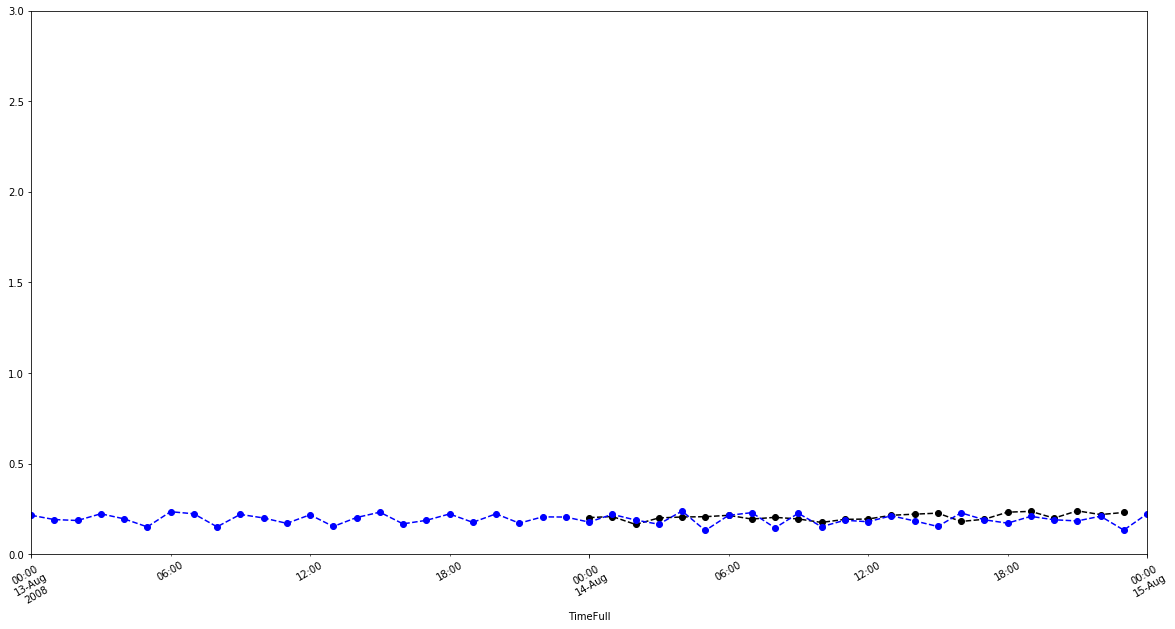

In [32]:
pltf[0].plot(kind='line',style='ko--',use_index=True,rot=30,ylim=[0.0,3.0],xlim=[pltf.index[pltf['Date2'] >= '2008-08-13'][0],pltf.index[pltf['Date2'] >= '2008-08-14'][24]],figsize=(20,10))
pltf['Global_active_power'].plot(kind='line',style='bo--',use_index=True,rot=30,ylim=[0.0,3.0],xlim=[pltf.index[pltf['Date2'] >= '2008-08-13'][0],pltf.index[pltf['Date2'] >= '2008-08-14'][24]],figsize=(20,10))

On the other hand, to see how the model also predicts for a different series, say we ask it to predict for a different series. See what we get.

In [33]:
if processedDF[processedDF['Date2'] == '2008-01'].iloc[0]['TimeHrs'] < 10:
    starttime = str(processedDF[(processedDF['Date2'] == '2008-08')].iloc[0]['Date2'])[:10]+' '+ '0' + str(processedDF[processedDF['Date2'] == '2008-08'].iloc[0]['TimeHrs'])+':00:00'
else:
    starttime = str(processedDF[(processedDF['Date2'] == '2008-08')].iloc[0]['Date2'])[:10]+' '+ str(processedDF[processedDF['Date2'] == '2008-08'].iloc[0]['TimeHrs'])+':00:00'

target = processedDF[(processedDF['Date2'] >= '2008-08-01') & (processedDF['Date2'] < '2008-08-14')]['Global_intensity'].tolist()
cat = [0,0]
dynfeat = [processedDF[(processedDF['Date2'] >= '2008-08-01') & (processedDF['Date2'] < '2008-08-15')]['distanceFromLastSolstice'].tolist(),processedDF[(processedDF['Date2'] >= '2008-08-01') & (processedDF['Date2'] < '2008-08-15')]['distanceFromNextSolstice'].tolist()]
instances = []

instances.append({
    "start": starttime,
    "target": target,
    "cat": cat,
    "dynamic_feat": dynfeat
})

request = {}
request['instances'] = instances
request['configuration'] = {}
request['configuration']['num_samples'] = 50
request['configuration']['output_types'] = ['mean']
json_request = json.dumps(request)

In [34]:
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/json', 
                                   Body=json_request)
result = json.loads(response['Body'].read().decode())
print(result)

{'predictions': [{'mean': [0.8886301517, 0.9159537554, 0.7416194677, 0.8516206145, 0.8483208418, 0.8817822933, 0.9169275165, 0.8365494609, 0.8921685219, 0.8741668463, 0.7856843472, 0.8761405945, 0.8715088367, 0.960237205, 1.0142562389, 1.0668101311, 0.8398330808, 0.9008331299, 1.0748158693, 1.0996569395, 0.9420467615, 1.124576211, 1.0516116619, 1.1171754599]}]}


Lets take this and plot it against the truth

In [35]:
pltFrame = processedDF.replace(to_replace="NaN",value=np.nan,regex=True)

def getTime(row):
    if row['TimeHrs'] < 10:
        return str(row['Date2'])[:10] + ' 0' + str(row['TimeHrs']) + ":00:00"
    else:
        return str(row['Date2'])[:10] + ' ' + str(row['TimeHrs']) + ":00:00"

pltFrame['TimeFull'] = pltFrame.apply(lambda row: getTime(row),axis=1)
pltFrame['TimeFull'] = pd.to_datetime(pltFrame['TimeFull'])
pltFrame.set_index('TimeFull',inplace=True)
predictions = pd.Series(data=result['predictions'][0]['mean'],index=pltFrame.index[pltFrame['Date2'] >= '2008-08-14'][:24])
pltf = pd.concat([pltFrame,predictions],axis=1)

## Check your dataframe
#pltf.loc[pltf.index[pltf['Date2'] >= '2008-08-14'][:30]]

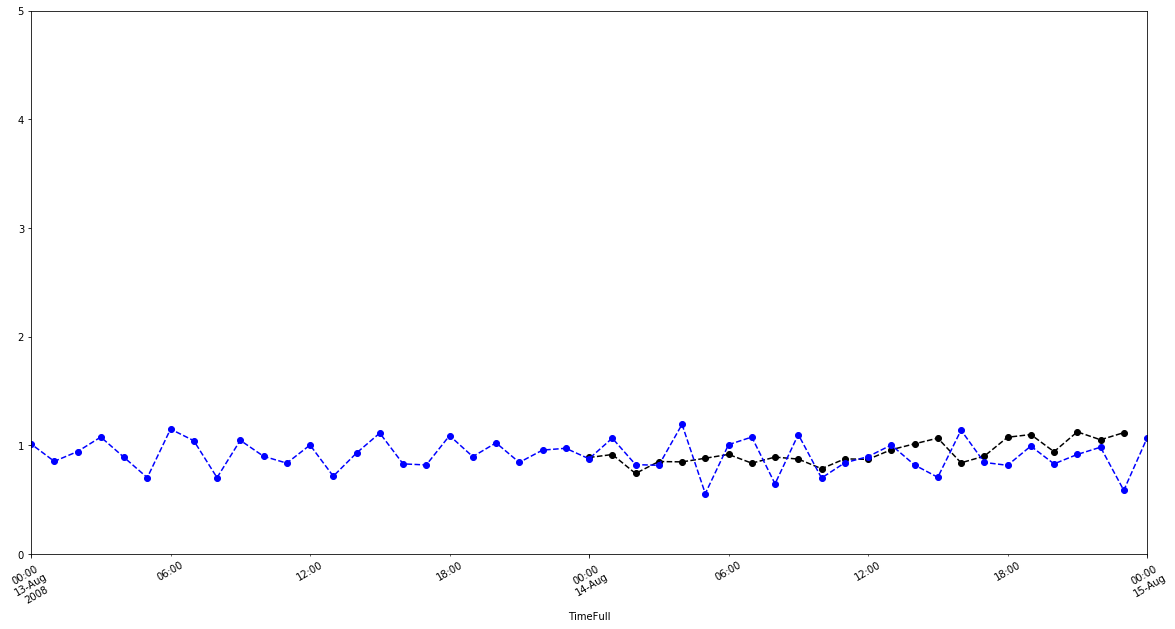

In [36]:
pltf[0].plot(kind='line',style='ko--',use_index=True,rot=30,ylim=[0.0,5.0],xlim=[pltf.index[pltf['Date2'] >= '2008-08-13'][0],pltf.index[pltf['Date2'] >= '2008-08-14'][24]],figsize=(20,10))
pltf['Global_intensity'].plot(kind='line',style='bo--',use_index=True,rot=30,ylim=[0.0,5.0],xlim=[pltf.index[pltf['Date2'] >= '2008-08-13'][0],pltf.index[pltf['Date2'] >= '2008-08-14'][24]],figsize=(20,10))

Lets delete the endpoint

In [37]:
sgmaker.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '67dc57e7-3802-4fa5-ad28-5bfdccc3c31d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '67dc57e7-3802-4fa5-ad28-5bfdccc3c31d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 01 Oct 2018 16:23:07 GMT'},
  'RetryAttempts': 0}}

## Automatic Model Tuning

In [38]:
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "0.2",
          "MinValue": "0.00",
          "Name": "dropout_rate"
        },
        {
          "MaxValue": "0.050",
          "MinValue": "0.001",
          "Name": "learning_rate"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "512",
          "MinValue": "64",
          "Name": "mini_batch_size"
        },
        {
          "MaxValue": "20",
          "MinValue": "10",
          "Name": "epochs"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 10,
      "MaxParallelTrainingJobs": 2
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "test:RMSE",
      "Type": "Minimize"
    }
  }

training_job_definition = \
{
    "AlgorithmSpecification": {
        "TrainingImage": img,
        "TrainingInputMode": "File"
    },
    "RoleArn": roleARN,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 4,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 10
    },
    "StaticHyperParameters": {
        "time_freq": 'H', # hourly series
        "context_length": str(context_length),
        "prediction_length": str(prediction_length), # number of data points to predict
        "num_dynamic_feat": "auto",
        "num_cells": "60", 
        "num_layers": "4",
        "likelihood": "gaussian"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 240 # Give it four hours at best, could increase this for production scale
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": training_path,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "test",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": testing_path,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}


In [39]:
tuning_job_name = "HPO-Tune-" + strftime("%H-%M-%S", gmtime())
hpo_tuning_job_arn = sgmaker.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)
print("HPO Job started, name of the HPO Job: {} and \n Tuning Job ARN: {}".format(tuning_job_name,hpo_tuning_job_arn['HyperParameterTuningJobArn']))

HPO Job started, name of the HPO Job: HPO-Tune-16-25-14 and 
 Tuning Job ARN: arn:aws:sagemaker:us-east-1:684473352813:hyper-parameter-tuning-job/hpo-tune-16-25-14


Create a Hyperparameeter tuner

In [40]:
import sagemaker.tuner as tun

hpo_tuner = tun.HyperparameterTuner.attach(tuning_job_name)


In [41]:
analysis = hpo_tuner.analytics()

In [44]:
analysis.dataframe(force_refresh=True)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,dropout_rate,epochs,learning_rate,mini_batch_size
0,18.994919,729.0,2018-10-01 17:17:02+00:00,HPO-Tune-16-25-14-010-09786c9d,Completed,2018-10-01 17:04:53+00:00,0.192124,20.0,0.010139,370.0
1,23.449408,147.0,2018-10-01 17:03:21+00:00,HPO-Tune-16-25-14-009-04eb6793,Completed,2018-10-01 17:00:54+00:00,0.076334,10.0,0.001789,64.0
2,343.415253,226.0,2018-10-01 17:01:25+00:00,HPO-Tune-16-25-14-008-5aaf7b4c,Completed,2018-10-01 16:57:39+00:00,0.098689,12.0,0.021494,88.0
3,7.831675,388.0,2018-10-01 16:57:39+00:00,HPO-Tune-16-25-14-007-de863ffe,Completed,2018-10-01 16:51:11+00:00,0.175772,13.0,0.001149,285.0
4,16.909111,245.0,2018-10-01 16:54:27+00:00,HPO-Tune-16-25-14-006-f892d336,Completed,2018-10-01 16:50:22+00:00,0.190274,13.0,0.011114,123.0
5,35.749325,339.0,2018-10-01 16:48:17+00:00,HPO-Tune-16-25-14-005-02e716a5,Completed,2018-10-01 16:42:38+00:00,0.022688,12.0,0.005519,167.0
6,19.065823,327.0,2018-10-01 16:46:51+00:00,HPO-Tune-16-25-14-004-8ec6d6c9,Completed,2018-10-01 16:41:24+00:00,0.183658,10.0,0.028968,172.0
7,85.052689,382.0,2018-10-01 16:38:12+00:00,HPO-Tune-16-25-14-003-d96543e0,Completed,2018-10-01 16:31:50+00:00,0.024268,13.0,0.012843,231.0
8,NaN,72.0,2018-10-01 16:29:15+00:00,HPO-Tune-16-25-14-002-ed7f091e,Failed,2018-10-01 16:28:03+00:00,0.075455,15.0,0.041002,75.0
9,1175.794312,762.0,2018-10-01 16:40:32+00:00,HPO-Tune-16-25-14-001-50d7e9ea,Completed,2018-10-01 16:27:50+00:00,0.110003,14.0,0.046835,502.0


In [45]:
predobj = hpo_tuner.deploy(1,'ml.m4.xlarge')

2018-10-01 16:48:36 Starting - Preparing the instances for training
2018-10-01 16:51:11 Downloading - Downloading input data
2018-10-01 16:51:20 Training - Training image download completed. Training in progress.
2018-10-01 16:57:30 Uploading - Uploading generated training model
2018-10-01 16:57:39 Completed - Training job completed

INFO:sagemaker:Creating model with name: forecasting-deepar-2018-10-01-17-42-54-098


Arguments: train
Arguments: train
Arguments: train
[10/01/2018 16:51:26 INFO 140088290715456] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[10/01/2018 16:51:26 INFO 140088290715456] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.17577224158449561', u'_tuning_objective_metric': u'test:RMSE', u'learning_rate': u'0.0011491169372165944', u'num_cells': u'60', u'prediction_length'

INFO:sagemaker:Creating endpoint with name HPO-Tune-16-25-14-007-de863ffe


----------------------------------------------------------------!

In [46]:
predobj.predict(json_request)

b'{"predictions":[{"mean":[1.0501497984,1.4032204151,1.0133697987,1.2503783703,1.2417641878,1.2623944283,1.3716146946,1.1025470495,1.2747721672,1.0614644289,0.876834631,1.1310921907,1.1453151703,1.3082934618,1.2679457664,1.3313109875,0.9887498617,1.0146009922,1.3495147228,1.1981393099,0.9242219329,1.3315390348,1.0903037786,1.0839303732]}]}'

In [67]:
predobj.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: HPO-Tune-16-58-41-004-d0db2d46
